<a href="https://colab.research.google.com/github/pjjongho/Colab_AD/blob/main/Time%20Series%20Insurance%20Fraud%20Detction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 22**  
**┗ 시계열 보험 청구 사기 감지**
---
> **목차(Context)**

* 문제상황 및 데이터 살펴보기
* 문제해결 프로세스 정의
* 🥉Session 1 - 「데이터 전처리 및 EDA」
* 🥈Session 2 - 「가설 수립 및 검증, 인사이트 발굴」
* 🥇Session 3 - 「이상 탐지 모델링」

# Prerequisites

$ pip install missingno, association-metrics

In [ ]:
location = 'local' # local에서 내려받아 실행시 'local'

In [ ]:
import warnings
import os
warnings.filterwarnings('ignore') # ▶ Warnings 제거

if location == 'colab' :
    from google.colab import drive
    drive.mount('/content/drive') # ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
    notebook_path = '/content/drive/MyDrive/Colab Notebooks' # ▶ 노트북 파일이 존재하는 경로 입력
    os.chdir(notebook_path)

# **문제상황 및 데이터 살펴보기**
---
> **시나리오** 🧑💗 (보험사 개발자/데이터분석가)
```
A 차량 보험사는 과거 고객의 행동 패턴을 추적하여, 보험 사기 감지 모델을 개발하려고 한다.
기존의 모델은 사고 데이터만 활용하여 개발된 모델이었으나
이외에 추가로 사고 발생 일자, 카테고리 데이터를 활용하여 모델을 개선하고자 한다.
```

> **데이터 살펴보기**

- 데이터로더 작성

In [ ]:
from typing import Union
from pathlib import Path
import pandas as pd
from data_loader import DataLoader

class DataLoader:
    def __init__(self, data_path:Union[str, Path]):
        self.data_path = data_path
    def load_data(self) -> pd.DataFrame:
        return (
            pd.read_csv(self.data_path/'data.csv', index_col=0)
        )

data_path = Path().cwd() / 'data' / 'chapter22'
data_loader = DataLoader(data_path=data_path)

In [ ]:
data = data_loader.load_data()

In [ ]:
data.T

0                    1      \
Make                                         Mazda              Pontiac   
AccidentArea                                 Urban                Urban   
Sex                                           Male               Female   
MaritalStatus                              Married               Single   
Age                                             60                   45   
Fault                                Policy Holder        Policy Holder   
PolicyType                       Sedan - Collision    Sedan - Liability   
VehicleCategory                              Sedan                Sport   
VehiclePrice                      20,000 to 29,000     less than 20,000   
PolicyNumber                                 10064                 2781   
RepNumber                                        3                   13   
Deductible                                     400                  400   
DriverRating                                     1                    1   
Days:Policy-Accident                  more than 30         more than 30   
Days:Policy-Claim                     more than 30         more than 30   
PastNumberOfClaims                          2 to 4          more than 4   
AgeOfVehicle                           more than 7              7 years   
AgeOfPolicyHolder                         51 to 65             36 to 40   
PoliceReportFiled                               No                   No   
WitnessPresent                                  No                   No   
AgentType                                 External             External   
NumberOfSuppliments                         3 to 5               1 to 2   
AddressChange-Claim                      no change            no change   
NumberOfCars                             1 vehicle            1 vehicle   
BasePolicy                               Collision            Liability   
FraudFound                                      No                   No   
Date_Accident                  2015-02-22 00:00:00  2015-11-27 00:00:00   
Date_Claimed                   2015-05-26 00:00:00  2015-11-27 00:00:00   
Days_To_Report                                  93                    0   
Date_Accident_Year                            2015                 2015   
Date_Accident_Month                              2                   11   
Date_Accident_Dayofmonth                        22                   27   
Date_Accident_Weekofmonth                        4                    4   
Date_Claimed_Year                             2015                 2015   
Date_Claimed_Month                               5                   11   
Date_Claimed_Dayofmonth                         26                   27   
Date_Claimed_Weekofmonth                         4                    4   
Date_Accident_Month_Cos                        0.5             0.866025   
Date_Accident_Dayofmonth_Cos             -0.250653             0.688967   
Date_Accident_Weekofmonth_Cos                  1.0                  1.0   
Date_Accident_Month_Sin                   0.866025                 -0.5   
Date_Accident_Dayofmonth_Sin             -0.968077            -0.724793   
Date_Accident_Weekofmonth_Sin                 -0.0                 -0.0   
Date_Claimed_Month_Cos                   -0.866025             0.866025   
Date_Claimed_Dayofmonth_Cos               0.528964             0.688967   
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0   
Date_Claimed_Month_Sin                         0.5                 -0.5   
Date_Claimed_Dayofmonth_Sin              -0.848644            -0.724793   
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0   

                                             2                    3      \
Make                                         Dodge                Mazda   
AccidentArea                                 Urban                Rural   
Sex                                           Male                 Ma

- Chargeback fraud 이해

![](figures/22_1.webp)


* Fraud data
* 사고 사례를 `FraudFound` 컬럼으로 보유중
* 데이터 명세 ⬇

In [ ]:
data.columns.tolist()

['Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Age',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars',
 'BasePolicy',
 'FraudFound',
 'Date_Accident',
 'Date_Claimed']

In [ ]:
data_description_dict = {
    'Make':'차량 메이커',
    'AccidentArea':'사고 지역',
    'Sex':'성별',
    'MaritalStatus':'기혼 여부',
    'Age':'나이',
    'Fault':'과실 책임',
    'PolicyType':'보험 형태',
    'VehicleCategory':'차량 카테고리',
    'VehiclePrice':'차량 가액',
    'PolicyNumber':'보험 형태 고유번호',
    'RepNumber':'',
    'Deductible':'보험 계약자 부담금액',
    'DriverRating':'운전자 등급',
    'Days:Policy-Accident':'사고 이후 날짜',
    'Days:Policy-Claim':'청구 이후 날짜',
    'PastNumberOfClaims':'과거 보험 청구 횟수',
    'AgeOfVehicle':'차량 연식',
    'AgeOfPolicyHolder':'보험 가입자 연령 범위',
    'PoliceReportFiled':'사고 신고 여부',
    'WitnessPresent':'',
    'AgentType':'에이전트 타입',
    'NumberOfSuppliments':'',
    'AddressChange-Claim':'주소 변경 여부',
    'NumberOfCars':'소유 차량 대수',
    'BasePolicy':'',
    'FraudFound':'과거 사기 여부',
    'Date_Accident':'사고 날짜',
    'Date_Claimed':'청구 날짜',
}

(
    data
    .append(
        data_description_dict,
        ignore_index=True
    )
    .iloc[[-1, 0, 1, 2, 3]]
    .T
    .rename(columns={13162:'데이터 설명', 0:'샘플 데이터 1', 1:'샘플 데이터 2', 2:'샘플 데이터 3', 3:'샘플 데이터 4'})
)

13162           샘플 데이터 1           샘플 데이터 2  \
Make                        차량 메이커              Mazda            Pontiac   
AccidentArea                 사고 지역              Urban              Urban   
Sex                             성별               Male             Female   
MaritalStatus                기혼 여부            Married             Single   
Age                             나이                 60                 45   
Fault                        과실 책임      Policy Holder      Policy Holder   
PolicyType                   보험 형태  Sedan - Collision  Sedan - Liability   
VehicleCategory            차량 카테고리              Sedan              Sport   
VehiclePrice                 차량 가액   20,000 to 29,000   less than 20,000   
PolicyNumber            보험 형태 고유번호              10064               2781   
RepNumber                                           3                 13   
Deductible             보험 계약자 부담금액                400                400   
DriverRating                운전자 등급                  1                  1   
Days:Policy-Accident      사고 이후 날짜       more than 30       more than 30   
Days:Policy-Claim         청구 이후 날짜       more than 30       more than 30   
PastNumberOfClaims     과거 보험 청구 횟수             2 to 4        more than 4   
AgeOfVehicle                 차량 연식        more than 7            7 years   
AgeOfPolicyHolder     보험 가입자 연령 범위           51 to 65           36 to 40   
PoliceReportFiled         사고 신고 여부                 No                 No   
WitnessPresent                                     No                 No   
AgentType                  에이전트 타입           External           External   
NumberOfSuppliments                            3 to 5             1 to 2   
AddressChange-Claim       주소 변경 여부          no change          no change   
NumberOfCars              소유 차량 대수          1 vehicle          1 vehicle   
BasePolicy                                  Collision          Liability   
FraudFound                과거 사기 여부                 No                 No   
Date_Accident                사고 날짜         2015-02-22         2015-11-27   
Date_Claimed                 청구 날짜         2015-05-26         2015-11-27   

                               샘플 데이터 3           샘플 데이터 4  
Make                              Dodge              Mazda  
AccidentArea                      Urban              Rural  
Sex                                Male               Male  
MaritalStatus                   Married             Single  
Age                                  49                 29  
Fault                     Policy Holder      Policy Holder  
PolicyType            Sedan - Liability  Sedan - Collision  
VehicleCategory                   Sport              Sedan  
VehiclePrice           more than 69,000   20,000 to 29,000  
PolicyNumber                       3458               3457  
RepNumber                            16                  4  
Deductible                          400                400  
DriverRating                          2                  1  
Days:Policy-Accident       more than 30       more than 30  
Days:Policy-Claim          more than 30       more than 30  
PastNumberOfClaims               2 to 4                  1  
AgeOfVehicle                    5 years            7 years  
AgeOfPolicyHolder              41 to 50           31 to 35  
PoliceReportFiled                    No                 No  
WitnessPresent                       No                 No  
AgentType                      External           External  
NumberOfSuppliments              3 to 5               none  
AddressChange-Claim           no change          no change  
NumberOfCars                  1 vehicle          1 vehicle  
BasePolicy                    Liability          Collision  
FraudFound                           No                Yes  
Date_Accident                2015-01-15         2015-05-10  
Date_Claimed                 2015-01-23         2015-05-26


# **문제해결 프로세스 정의**
---
> **문제정의**

```
▶ 카테고리, 시계열 데이터를 활용하여 보험 청구 사기 모델 강화
```  

> **기대효과**

```
▶ 사고 피해액 감소
```

> **해결방안**

```
▶ 과거 보험 청구 데이터를 바탕으로 사기 예측 모델을 개발
▶ Session 1 🥉
 - Data 전처리 및 EDA
▶ Session 2 🥈
 - 가설 수립 및 검증, 인사이트 발굴
▶ Session 3 🥇
 - 이상 탐지 모델링
```

> **성과측정**  

```
▶ 디플로이 이후 기간동안 사기 검거율을 측정하여 성과 평가
```

> **현업적용**  

```
▶ Model에 Input하기 위한 Data mart 생성
▶ 예측 모델 활용을 위한 사고 데이터 수집
```



# **🥉Session 1**  
**┗ 데이터 전처리 및 EDA**  
---

### · Data 이해
---
* 수집된 데이터의 기본 정보들을 확인  

#### (1) Data shape(형태) 확인
- 얼마나 많은 Record(row)가 있는지, 사용할 수 있는 Feature(column)의 수가 얼마나 되는지 확인



In [ ]:
data.shape

(13162, 28)

#### (2) Data type 확인
- Categorical, numerical feature가 얼마나 있는지 확인

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13162 entries, 0 to 15419
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Make                  13162 non-null  object
 1   AccidentArea          13162 non-null  object
 2   Sex                   13162 non-null  object
 3   MaritalStatus         13162 non-null  object
 4   Age                   13162 non-null  int64 
 5   Fault                 13162 non-null  object
 6   PolicyType            13162 non-null  object
 7   VehicleCategory       13162 non-null  object
 8   VehiclePrice          13162 non-null  object
 9   PolicyNumber          13162 non-null  int64 
 10  RepNumber             13162 non-null  int64 
 11  Deductible            13162 non-null  int64 
 12  DriverRating          13162 non-null  int64 
 13  Days:Policy-Accident  13162 non-null  object
 14  Days:Policy-Claim     13162 non-null  object
 15  PastNumberOfClaims    13162 non-null

#### (3) Null값 확인 (※ 빈 값의 Data)
- 빈 값이 있을 경우 모델에서 Null값을 핸들링해주는지 확인
- 또는 Imputation을 통해 빈 값을 채워주거나
- Imputation이 어려울 경우 해당 Row를 제거하는 방법도 고려하여야 함

In [ ]:
data.isna()

Make  AccidentArea    Sex  MaritalStatus    Age  Fault  PolicyType  \
0      False         False  False          False  False  False       False   
1      False         False  False          False  False  False       False   
2      False         False  False          False  False  False       False   
3      False         False  False          False  False  False       False   
4      False         False  False          False  False  False       False   
...      ...           ...    ...            ...    ...    ...         ...   
15415  False         False  False          False  False  False       False   
15416  False         False  False          False  False  False       False   
15417  False         False  False          False  False  False       False   
15418  False         False  False          False  False  False       False   
15419  False         False  False          False  False  False       False   

       VehicleCategory  VehiclePrice  PolicyNumber  ...  PoliceReportFiled  \
0                False         False         False  ...              False   
1                False         False         False  ...              False   
2                False         False         False  ...              False   
3                False         False         False  ...              False   
4                False         False         False  ...              False   
...                ...           ...           ...  ...                ...   
15415            False         False         False  ...              False   
15416            False         False         False  ...              False   
15417            False         False         False  ...              False   
15418            False         False         False  ...              False   
15419            False         False         False  ...              False   

       WitnessPresent  AgentType  NumberOfSuppliments  AddressChange-Claim  \
0               False      False                False                False   
1               False      False                False                False   
2               False      False                False                False   
3               False      False                False                False   
4               False      False                False                False   
...               ...        ...                  ...                  ...   
15415           False      False                False                False   
15416           False      False                False                False   
15417           False      False                False                False   
15418           False      False                False                False   
15419           False      False                False                False   

       NumberOfCars  BasePolicy  FraudFound  Date_Accident  Date_Claimed  
0             False       False       False          False         False  
1             False       False       False          False         False  
2             False       False       False          False         False  
3             False       False       False          False         False  
4             False       False       False          False         False  
...             ...         ...         ...            ...           ...  
15415         False       False       False          False         False  
15416         False       False       False          False         False  
15417         False       False       False          False         False  
15418         False       False       False          False         False  
15419         False       False       False          False         False  

[13162 rows x 28 columns]

In [ ]:
data.isna().sum()

Make                             0
AccidentArea                     0
Sex                              0
MaritalStatus                    0
Age                              0
Fault                            0
PolicyType                       0
VehicleCategory                  0
VehiclePrice                     0
PolicyNumber                     0
RepNumber                        0
Deductible                       0
DriverRating                     0
Days:Policy-Accident             0
Days:Policy-Claim                0
PastNumberOfClaims               0
AgeOfVehicle                     0
AgeOfPolicyHolder                0
PoliceReportFiled                0
WitnessPresent                   0
AgentType                        0
NumberOfSuppliments              0
AddressChange-Claim              0
NumberOfCars                     0
BasePolicy                       0
FraudFound                       0
Date_Accident                    0
Date_Claimed                     0
Days_To_Report      

Text(0.5, 1.0, 'User data')

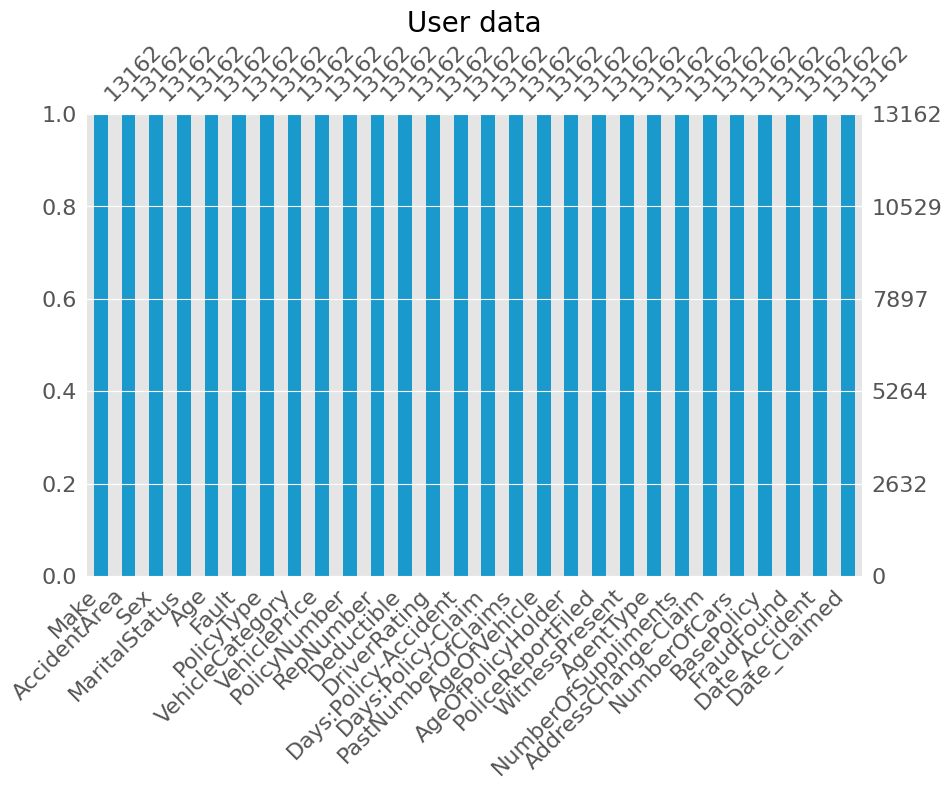

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
plt.style.use('ggplot')

msno.bar(df=data, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('User data', fontsize=20)

Text(0.5, 1.0, 'User data')

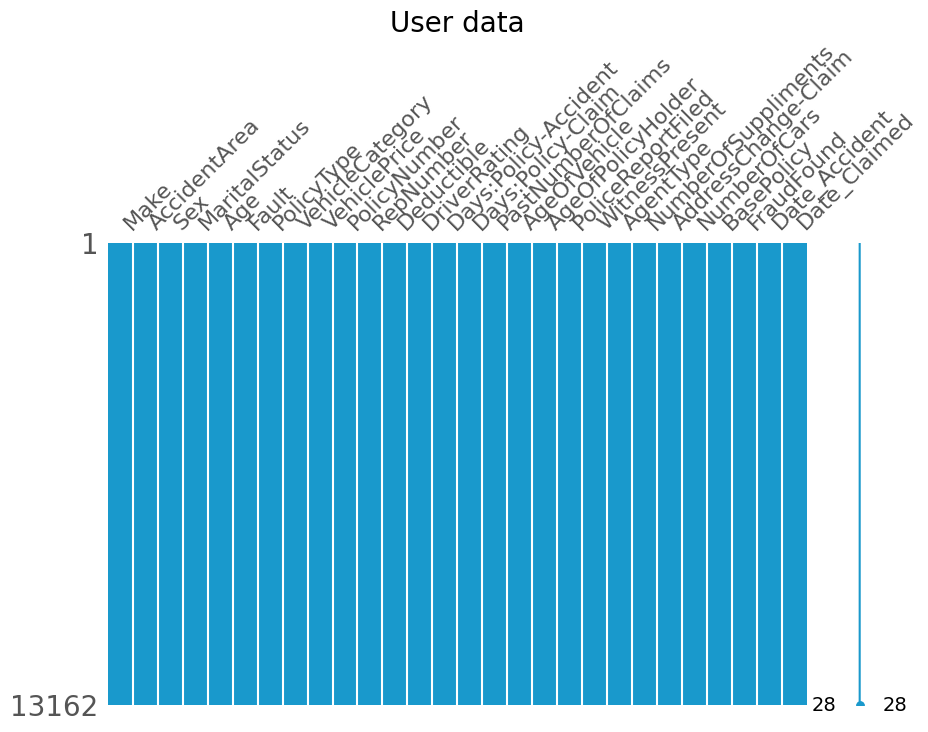

In [ ]:
msno.matrix(df=data, color=(0.1, 0.6, 0.8), figsize=(10, 6))
plt.title('User data', fontsize=20)

#### (4) # of unique values, data distribution, outlier 확인 (※ 정상적인 범주를 벗어난 Data)

- number of unique values : 예측에 사용할 수 있는 유의미한 정보를 담은 Column인지, 단순 ID 등의 의미없는 Column인지 확인
- Distribution : 학습에 방해가 될 수 있는 불균형한 데이터셋인지 확인. Label이 Imbalanced한 경우 Novelty dectection 등의 모델을 고려하여야 함
- Outlier 확인 : 모델 학습에 방해가 될 수 있는 Outlier 등이 존재하는지 확인


In [ ]:
(
    data
    .nunique()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'column_name', 0:'number_of_unique_values'})
)

column_name  number_of_unique_values
0                   Make                       18
1           AccidentArea                        2
2                    Sex                        2
3          MaritalStatus                        4
4                    Age                       66
5                  Fault                        2
6             PolicyType                        9
7        VehicleCategory                        3
8           VehiclePrice                        6
9           PolicyNumber                    10258
10             RepNumber                       16
11            Deductible                        4
12          DriverRating                        4
13  Days:Policy-Accident                        5
14     Days:Policy-Claim                        3
15    PastNumberOfClaims                        4
16          AgeOfVehicle                        8
17     AgeOfPolicyHolder                        9
18     PoliceReportFiled                        2
19        WitnessPresent                        2
20             AgentType                        2
21   NumberOfSuppliments                        4
22   AddressChange-Claim                        5
23          NumberOfCars                        5
24            BasePolicy                        3
25            FraudFound                        2
26         Date_Accident                      721
27          Date_Claimed                      658

Text(0, 0.5, 'Fraud')

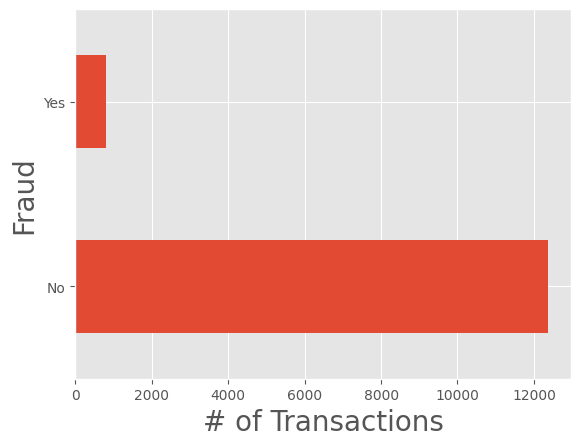

In [ ]:
(
    data['FraudFound']
    .value_counts()
    .plot(kind='barh')
)
plt.xlabel('# of Transactions', fontsize=20)
plt.ylabel('Fraud', fontsize=20)

In [ ]:
(
    data['FraudFound']
    .value_counts()
)

No     12363
Yes      799
Name: FraudFound, dtype: int64

### · EDA로부터 얻은 인사이트
---
#### (1) 결측치 존재하지 않는 데이터
#### (2) Row, column 수 둘다 많음
#### (3) Fraud의 데이터 수가 적은 불균형한 데이터셋

# **🥈Session 2**  
**┗ 가설 수립 및 검증, 인사이트 발굴**  
---

### · 가설 수립
- EDA : 데이터를 보고 떠올리거나
- 문헌조사 : 관련 논문, 업계 리포트, 뉴스 등을 참조하거나
- 인터뷰 : 관련 부서 담당자분들께 아이디어를 얻음
---
#### (1) 데이터에 있는 시계열적인 특성을 이용하여 어떠한 특징을 발견할 수 있는지?
#### (2) 카테고리 데이터를 인코딩해서 성능을 향상시킬 수 있는지?

### · 가설 검증 및 인사이트 발굴
---

#### (1) 데이터에 있는 시계열적인 특성을 이용하여 어떠한 특성을 발견할 수 있는지?

In [ ]:
data.iloc[:2].T

0                  1
Make                              Mazda            Pontiac
AccidentArea                      Urban              Urban
Sex                                Male             Female
MaritalStatus                   Married             Single
Age                                  60                 45
Fault                     Policy Holder      Policy Holder
PolicyType            Sedan - Collision  Sedan - Liability
VehicleCategory                   Sedan              Sport
VehiclePrice           20,000 to 29,000   less than 20,000
PolicyNumber                      10064               2781
RepNumber                             3                 13
Deductible                          400                400
DriverRating                          1                  1
Days:Policy-Accident       more than 30       more than 30
Days:Policy-Claim          more than 30       more than 30
PastNumberOfClaims               2 to 4        more than 4
AgeOfVehicle                more than 7            7 years
AgeOfPolicyHolder              51 to 65           36 to 40
PoliceReportFiled                    No                 No
WitnessPresent                       No                 No
AgentType                      External           External
NumberOfSuppliments              3 to 5             1 to 2
AddressChange-Claim           no change          no change
NumberOfCars                  1 vehicle          1 vehicle
BasePolicy                    Collision          Liability
FraudFound                           No                 No
Date_Accident                2015-02-22         2015-11-27
Date_Claimed                 2015-05-26         2015-11-27

In [ ]:
'2015-02-22' - '2015-02-20'

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
pd.Timestamp('2015-02-22') - pd.Timestamp('2015-02-20')

Timedelta('2 days 00:00:00')

In [ ]:
data['Date_Accident']

0       2015-02-22
1       2015-11-27
2       2015-01-15
3       2015-05-10
4       2015-11-17
           ...    
15415   2016-05-25
15416   2016-07-26
15417   2016-12-12
15418   2016-09-13
15419   2016-10-26
Name: Date_Accident, Length: 13162, dtype: datetime64[ns]

In [ ]:
data = (
    data
    .assign(Date_Accident=lambda x : pd.to_datetime(x['Date_Accident']))
    .assign(Date_Claimed=lambda x : pd.to_datetime(x['Date_Claimed']))
    .assign(Days_To_Report=lambda x : x['Date_Claimed']-x['Date_Accident'])
)
data.loc[:, ['Date_Accident', 'Date_Claimed', 'Days_To_Report']]

Date_Accident Date_Claimed Days_To_Report
0        2015-02-22   2015-05-26        93 days
1        2015-11-27   2015-11-27         0 days
2        2015-01-15   2015-01-23         8 days
3        2015-05-10   2015-05-26        16 days
4        2015-11-17   2015-12-21        34 days
...             ...          ...            ...
15415    2016-05-25   2016-05-26         1 days
15416    2016-07-26   2016-07-27         1 days
15417    2016-12-12   2016-12-15         3 days
15418    2016-09-13   2016-09-19         6 days
15419    2016-10-26   2016-10-27         1 days

[13162 rows x 3 columns]

In [ ]:
(pd.Timestamp('2015-02-22') - pd.Timestamp('2015-02-20')).days

2

In [ ]:
data['Days_To_Report']

0        93
1         0
2         8
3        16
4        34
         ..
15415     1
15416     1
15417     3
15418     6
15419     1
Name: Days_To_Report, Length: 13162, dtype: int64

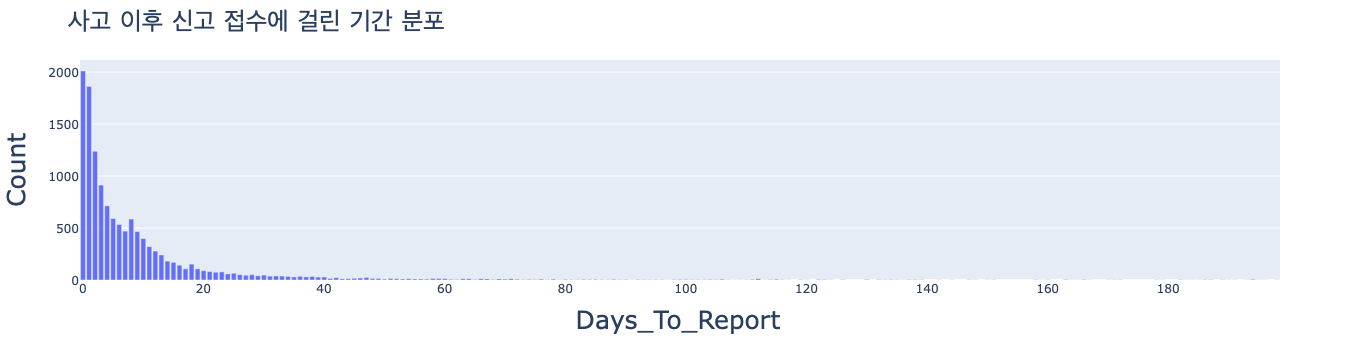

Days_To_Report  Count
0                 0   2010
1                 1   1862
2                 2   1238
3                 3    913
4                 4    713
..              ...    ...
161             124      1
162             170      1
163             167      1
164             159      1
165             196      1

[166 rows x 2 columns]

In [ ]:
import plotly.express as px

data_toplot = (
    data
    ['Days_To_Report'].dt.days.astype(int)
    .value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Days_To_Report', 'Days_To_Report':'Count'})
)

fig = px.bar(
    data_toplot,
    x='Days_To_Report',
    y='Count'
)

fig.update_layout(
    title=dict(
        text=f'사고 이후 신고 접수에 걸린 기간 분포',
        font=dict(size=25),
    ),
    xaxis_title=dict(
        text='Days_To_Report',
        font=dict(size=25),
    ),
    yaxis_title=dict(
        text="Count",
        font=dict(size=25),
    ),
)
fig.show()

display(data_toplot)

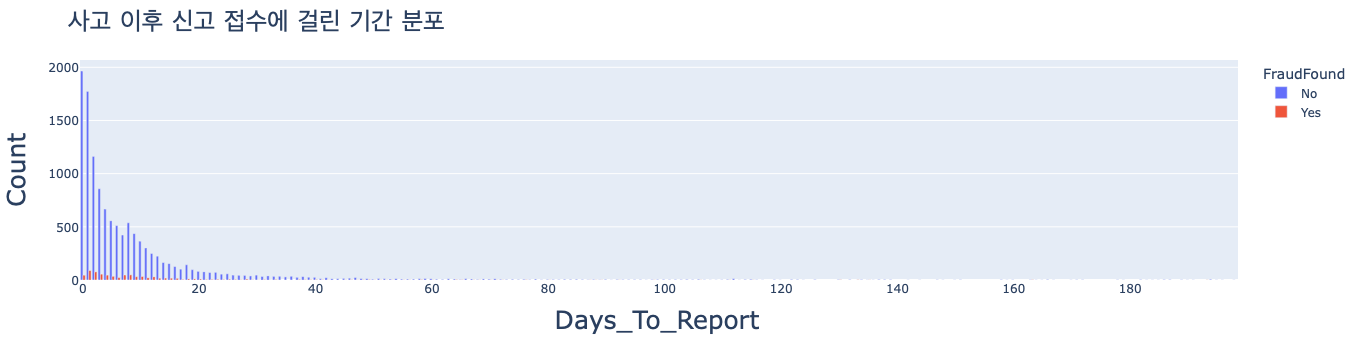

FraudFound  Days_To_Report  Count
0           No               0   1965
1           No               1   1773
2           No               2   1162
3           No               3    858
4           No               4    667
..         ...             ...    ...
234        Yes             106      1
235        Yes             111      1
236        Yes             115      1
237        Yes             135      1
238        Yes             193      1

[239 rows x 3 columns]

In [ ]:
data_toplot = (
    data
    .groupby(['FraudFound'])
    ['Days_To_Report'].value_counts()
    .to_frame()
    .rename(columns={'Days_To_Report':'Count'})
    .reset_index(drop=False)
    .assign(Days_To_Report=lambda x: x['Days_To_Report'].dt.days.astype(int))
)

fig = px.bar(
    data_toplot,
    x='Days_To_Report',
    y='Count',
    color='FraudFound',
    barmode='group'
)

fig.update_layout(
        title=dict(
            text=f'사고 이후 신고 접수에 걸린 기간 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text='Days_To_Report',
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
fig.show()

display(data_toplot)

In [ ]:
data.loc[:, ['Date_Accident', 'Date_Claimed', 'Days_To_Report']]

Date_Accident Date_Claimed Days_To_Report
0        2015-02-22   2015-05-26        93 days
1        2015-11-27   2015-11-27         0 days
2        2015-01-15   2015-01-23         8 days
3        2015-05-10   2015-05-26        16 days
4        2015-11-17   2015-12-21        34 days
...             ...          ...            ...
15415    2016-05-25   2016-05-26         1 days
15416    2016-07-26   2016-07-27         1 days
15417    2016-12-12   2016-12-15         3 days
15418    2016-09-13   2016-09-19         6 days
15419    2016-10-26   2016-10-27         1 days

[13162 rows x 3 columns]

In [ ]:
data = (
    data
    .assign(Date_Accident_Year=lambda x : x['Date_Accident'].dt.year)
    .assign(Date_Accident_Month=lambda x : x['Date_Accident'].dt.month)
    .assign(Date_Accident_Dayofmonth=lambda x : x['Date_Accident'].dt.day)
    .assign(Date_Accident_Weekofmonth=lambda x : x['Date_Accident_Dayofmonth'].apply(lambda d: (d-1) // 7 + 1))
    .assign(Date_Claimed_Year=lambda x : x['Date_Claimed'].dt.year)
    .assign(Date_Claimed_Month=lambda x : x['Date_Claimed'].dt.month)
    .assign(Date_Claimed_Dayofmonth=lambda x : x['Date_Claimed'].dt.day)
    .assign(Date_Claimed_Weekofmonth=lambda x : x['Date_Claimed_Dayofmonth'].apply(lambda d: (d-1) // 7 + 1))
)

In [ ]:
data.iloc[:2].T.iloc[25:]

0                    1
FraudFound                                  No                   No
Date_Accident              2015-02-22 00:00:00  2015-11-27 00:00:00
Date_Claimed               2015-05-26 00:00:00  2015-11-27 00:00:00
Days_To_Report                93 days 00:00:00      0 days 00:00:00
Date_Accident_Year                        2015                 2015
Date_Accident_Month                          2                   11
Date_Accident_Dayofmonth                    22                   27
Date_Accident_Weekofmonth                    4                    4
Date_Claimed_Year                         2015                 2015
Date_Claimed_Month                           5                   11
Date_Claimed_Dayofmonth                     26                   27
Date_Claimed_Weekofmonth                     4                    4

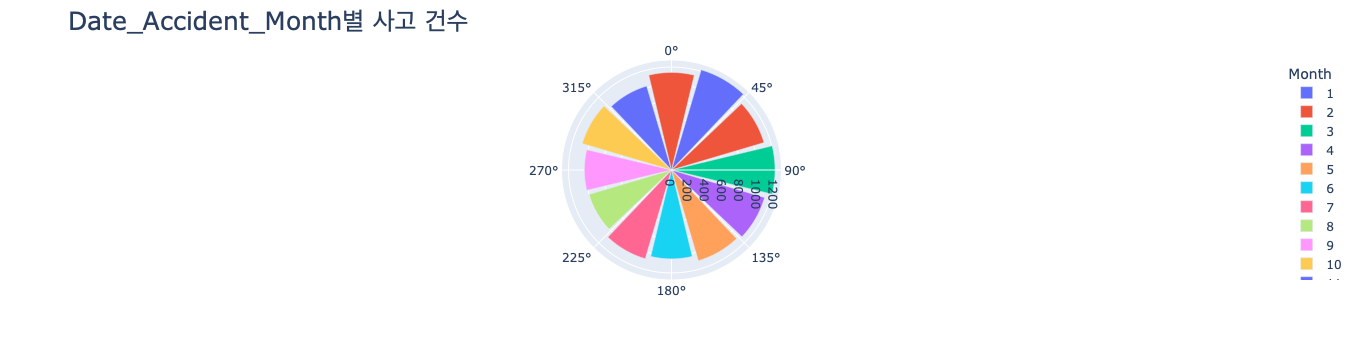

Month  Count  Month_To_Theta
0      1   1218            30.0
4      2   1125            60.0
1      3   1207            90.0
3      4   1132           120.0
5      5   1103           150.0
8      6   1036           180.0
7      7   1079           210.0
11     8   1003           240.0
10     9   1016           270.0
6     10   1085           300.0
9     11   1021           330.0
2     12   1137           360.0

In [ ]:
column = 'Date_Accident_Month'

data_toplot = (
    data
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Month', column:'Count'})
    .sort_values(by='Month')
    .assign(Month_To_Theta=lambda x : x['Month']*360/12)
    .assign(Month=lambda x : x['Month'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Month_To_Theta",
    color='Month'
)

fig.update_layout(
    title=dict(
        text=f'{column}별 사고 건수',
        font=dict(size=25),
    ),
)

fig.show()

display(data_toplot)

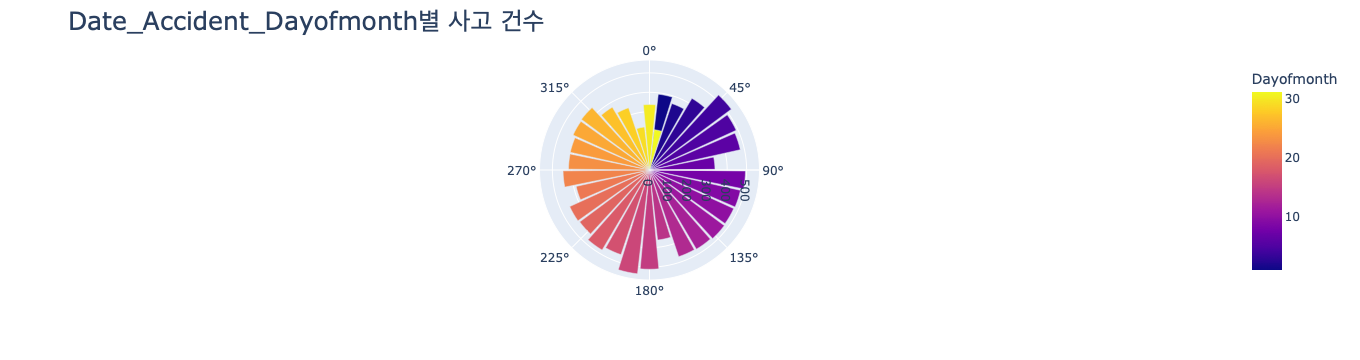

Dayofmonth  Count  Dayofmonth_To_Theta Month
21           1    393                 12.0     1
25           2    361                 24.0     2
18           3    429                 36.0     3
1            4    525                 48.0     4
4            5    491                 60.0     5
8            6    479                 72.0     6
27           7    337                 84.0     7
3            8    494                 96.0     8
5            9    480                108.0     9
9           10    477                120.0    10
6           11    480                132.0    11
10          12    474                144.0    12
11          13    471                156.0    13
24          14    363                168.0    14
2           15    511                180.0    15
0           16    538                192.0    16
12          17    460                204.0    17
7           18    479                216.0    18
14          19    448                228.0    19
13          20    452                240.0    20
22          21    387                252.0    21
15          22    445                264.0    22
20          23    417                276.0    23
19          24    418                288.0    24
17          25    433                300.0    25
16          26    437                312.0    26
23          27    376                324.0    27
26          28    338                336.0    28
29          29    223                348.0    29
28          30    337                360.0    30
30          31    209                372.0    31

In [ ]:
column = 'Date_Accident_Dayofmonth'

data_toplot = (
    data
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Dayofmonth', column:'Count'})
    .sort_values(by='Dayofmonth')
    .assign(Dayofmonth_To_Theta=lambda x : x['Dayofmonth']*360/30)
    .assign(Month=lambda x : x['Dayofmonth'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Dayofmonth_To_Theta",
    color='Dayofmonth'
)

fig.update_layout(
        title=dict(
            text=f'{column}별 사고 건수',
            font=dict(size=25),
        ),
    )

fig.show()

display(data_toplot)

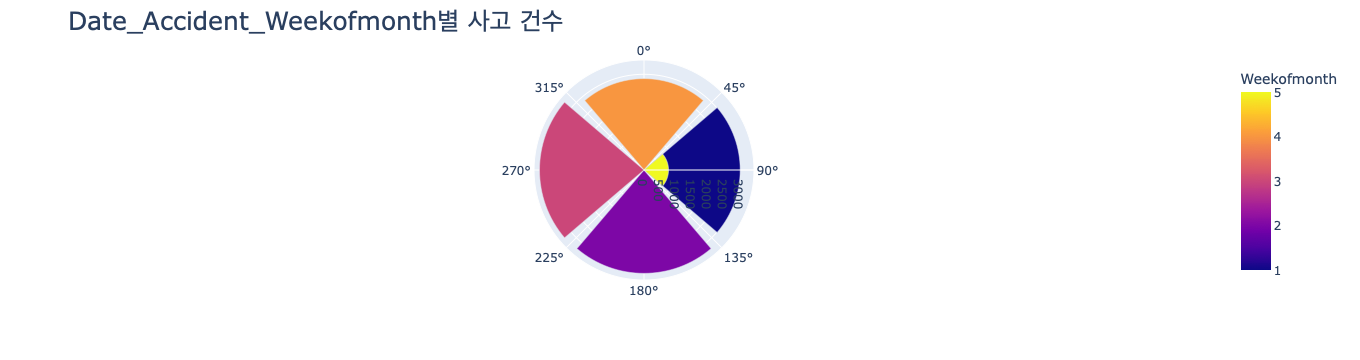

Weekofmonth  Count  Weekofmonth_To_Theta Month
2            1   3015                  90.0     1
1            2   3239                 180.0     2
0            3   3275                 270.0     3
3            4   2864                 360.0     4
4            5    769                 450.0     5

In [ ]:
column = 'Date_Accident_Weekofmonth'

data_toplot = (
    data
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Weekofmonth', column:'Count'})
    .sort_values(by='Weekofmonth')
    .assign(Weekofmonth_To_Theta=lambda x : x['Weekofmonth']*360/4)
    .assign(Month=lambda x : x['Weekofmonth'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Weekofmonth_To_Theta",
    color='Weekofmonth'
)

fig.update_layout(
        title=dict(
            text=f'{column}별 사고 건수',
            font=dict(size=25),
        ),
    )

fig.show()

display(data_toplot)

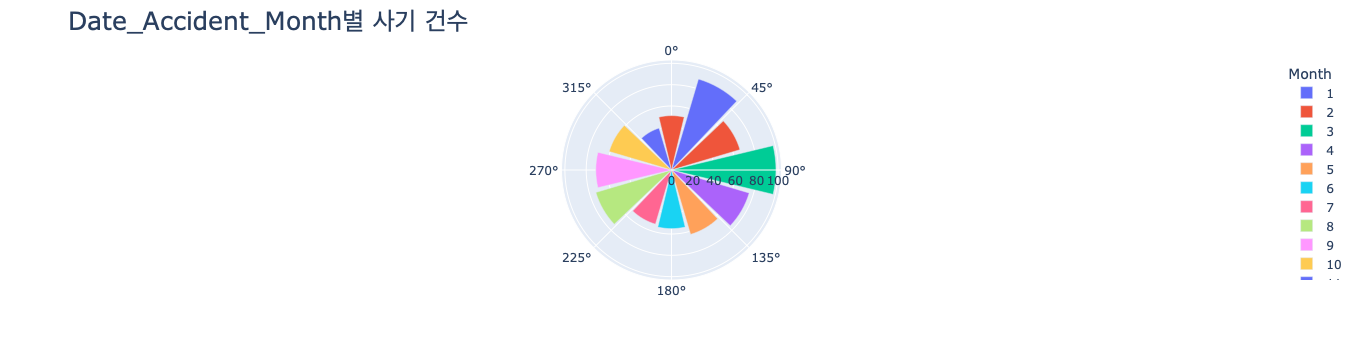

Month  Count  Month_To_Theta
1      1     89            30.0
5      2     67            60.0
0      3     98            90.0
2      4     76           120.0
6      5     63           150.0
8      6     55           180.0
9      7     53           210.0
3      8     74           240.0
4      9     71           270.0
7     10     61           300.0
11    11     41           330.0
10    12     51           360.0

In [ ]:
column = 'Date_Accident_Month'

data_toplot = (
    data
    .loc[lambda x : x['FraudFound']=='Yes']
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Month', column:'Count'})
    .sort_values(by='Month')
    .assign(Month_To_Theta=lambda x : x['Month']*360/12)
    .assign(Month=lambda x : x['Month'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Month_To_Theta",
    color='Month'
)

fig.update_layout(
        title=dict(
            text=f'{column}별 사기 건수',
            font=dict(size=25),
        ),
    )

fig.show()

display(data_toplot)

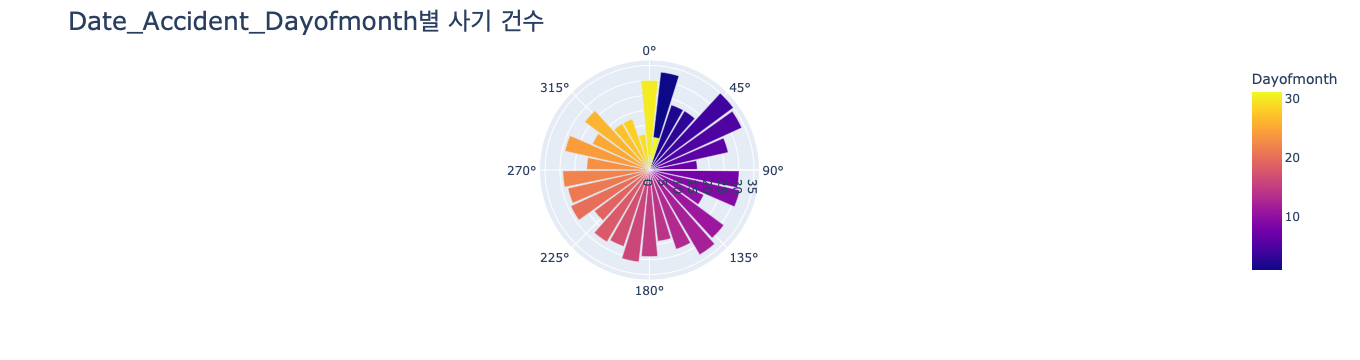

Dayofmonth  Count  Dayofmonth_To_Theta Month
2            1     33                 12.0     1
20           2     23                 24.0     2
21           3     23                 36.0     3
0            4     35                 48.0     4
1            5     34                 60.0     5
18           6     27                 72.0     6
28           7     16                 84.0     7
8            8     30                 96.0     8
4            9     31                108.0     9
25          10     20                120.0    10
6           11     31                132.0    11
3           12     33                144.0    12
14          13     28                156.0    13
19          14     24                168.0    14
12          15     29                180.0    15
5           16     31                192.0    16
17          17     27                204.0    17
15          18     28                216.0    18
22          19     23                228.0    19
10          20     29                240.0    20
13          21     28                252.0    21
9           22     29                264.0    22
24          23     21                276.0    23
11          24     29                288.0    24
23          25     21                300.0    25
16          26     27                312.0    26
27          27     18                324.0    27
26          28     18                336.0    28
29          29     12                348.0    29
7           30     30                360.0    30
30          31     11                372.0    31

In [ ]:
column = 'Date_Accident_Dayofmonth'

data_toplot = (
    data
    .loc[lambda x : x['FraudFound']=='Yes']
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Dayofmonth', column:'Count'})
    .sort_values(by='Dayofmonth')
    .assign(Dayofmonth_To_Theta=lambda x : x['Dayofmonth']*360/30)
    .assign(Month=lambda x : x['Dayofmonth'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Dayofmonth_To_Theta",
    color='Dayofmonth'
)

fig.update_layout(
        title=dict(
            text=f'{column}별 사기 건수',
            font=dict(size=25),
        ),
    )

fig.show()

display(data_toplot)

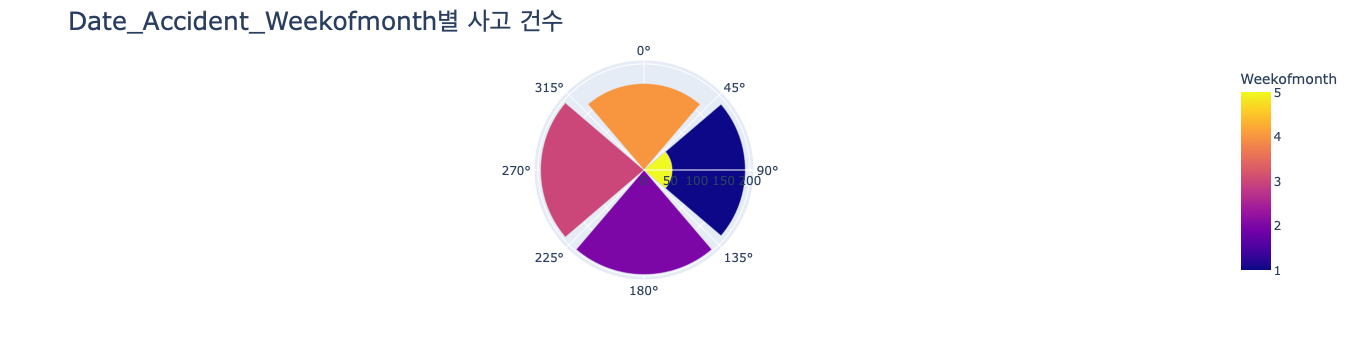

Weekofmonth  Count  Weekofmonth_To_Theta Month
2            1    191                  90.0     1
0            2    197                 180.0     2
1            3    195                 270.0     3
3            4    163                 360.0     4
4            5     53                 450.0     5

In [ ]:
column = 'Date_Accident_Weekofmonth'

data_toplot = (
    data
    .loc[lambda x : x['FraudFound']=='Yes']
    [column].value_counts()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'Weekofmonth', column:'Count'})
    .sort_values(by='Weekofmonth')
    .assign(Weekofmonth_To_Theta=lambda x : x['Weekofmonth']*360/4)
    .assign(Month=lambda x : x['Weekofmonth'].astype(str))
)

fig = px.bar_polar(
    data_toplot,
    r="Count",
    theta="Weekofmonth_To_Theta",
    color='Weekofmonth'
)

fig.update_layout(
        title=dict(
            text=f'{column}별 사고 건수',
            font=dict(size=25),
        ),
    )

fig.show()

display(data_toplot)

![](figures/22_1.gif)

In [ ]:
import numpy as np

data = (
    data
    .assign(Date_Accident_Month_Cos=lambda x : np.cos(x['Date_Accident_Month']*2*np.pi/12))
    .assign(Date_Accident_Dayofmonth_Cos=lambda x : np.cos(x['Date_Accident_Dayofmonth']*2*np.pi/31))
    .assign(Date_Accident_Weekofmonth_Cos=lambda x : np.cos(x['Date_Accident_Weekofmonth']*2*np.pi/4))
    .assign(Date_Accident_Month_Sin=lambda x : np.sin(x['Date_Accident_Month']*2*np.pi/12))
    .assign(Date_Accident_Dayofmonth_Sin=lambda x : np.sin(x['Date_Accident_Dayofmonth']*2*np.pi/31))
    .assign(Date_Accident_Weekofmonth_Sin=lambda x : np.sin(x['Date_Accident_Weekofmonth']*2*np.pi/4))
    .assign(Date_Claimed_Month_Cos=lambda x : np.cos(x['Date_Claimed_Month']*2*np.pi/12))
    .assign(Date_Claimed_Dayofmonth_Cos=lambda x : np.cos(x['Date_Claimed_Dayofmonth']*2*np.pi/31))
    .assign(Date_Claimed_Weekofmonth_Cos=lambda x : np.cos(x['Date_Claimed_Weekofmonth']*2*np.pi/4))
    .assign(Date_Claimed_Month_Sin=lambda x : np.sin(x['Date_Claimed_Month']*2*np.pi/12))
    .assign(Date_Claimed_Dayofmonth_Sin=lambda x : np.sin(x['Date_Claimed_Dayofmonth']*2*np.pi/31))
    .assign(Date_Claimed_Weekofmonth_Sin=lambda x : np.sin(x['Date_Claimed_Weekofmonth']*2*np.pi/4))
)

In [ ]:
data.iloc[:4].T.iloc[25:]

0                    1  \
FraudFound                                      No                   No   
Date_Accident                  2015-02-22 00:00:00  2015-11-27 00:00:00   
Date_Claimed                   2015-05-26 00:00:00  2015-11-27 00:00:00   
Days_To_Report                    93 days 00:00:00      0 days 00:00:00   
Date_Accident_Year                            2015                 2015   
Date_Accident_Month                              2                   11   
Date_Accident_Dayofmonth                        22                   27   
Date_Accident_Weekofmonth                        4                    4   
Date_Claimed_Year                             2015                 2015   
Date_Claimed_Month                               5                   11   
Date_Claimed_Dayofmonth                         26                   27   
Date_Claimed_Weekofmonth                         4                    4   
Date_Accident_Month_Cos                        0.5             0.866025   
Date_Accident_Dayofmonth_Cos             -0.250653             0.688967   
Date_Accident_Weekofmonth_Cos                  1.0                  1.0   
Date_Accident_Month_Sin                   0.866025                 -0.5   
Date_Accident_Dayofmonth_Sin             -0.968077            -0.724793   
Date_Accident_Weekofmonth_Sin                 -0.0                 -0.0   
Date_Claimed_Month_Cos                   -0.866025             0.866025   
Date_Claimed_Dayofmonth_Cos               0.528964             0.688967   
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0   
Date_Claimed_Month_Sin                         0.5                 -0.5   
Date_Claimed_Dayofmonth_Sin              -0.848644            -0.724793   
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0   

                                                 2                    3  
FraudFound                                      No                  Yes  
Date_Accident                  2015-01-15 00:00:00  2015-05-10 00:00:00  
Date_Claimed                   2015-01-23 00:00:00  2015-05-26 00:00:00  
Days_To_Report                     8 days 00:00:00     16 days 00:00:00  
Date_Accident_Year                            2015                 2015  
Date_Accident_Month                              1                    5  
Date_Accident_Dayofmonth                        15                   10  
Date_Accident_Weekofmonth                        3                    2  
Date_Claimed_Year                             2015                 2015  
Date_Claimed_Month                               1                    5  
Date_Claimed_Dayofmonth                         23                   26  
Date_Claimed_Weekofmonth                         4                    4  
Date_Accident_Month_Cos                   0.866025            -0.866025  
Date_Accident_Dayofmonth_Cos             -0.994869            -0.440394  
Date_Accident_Weekofmonth_Cos                 -0.0                 -1.0  
Date_Accident_Month_Sin                        0.5                  0.5  
Date_Accident_Dayofmonth_Sin              0.101168             0.897805  
Date_Accident_Weekofmonth_Sin                 -1.0                  0.0  
Date_Claimed_Month_Cos                    0.866025            -0.866025  
Date_Claimed_Dayofmonth_Cos              -0.050649             0.528964  
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0  
Date_Claimed_Month_Sin                         0.5                  0.5  
Date_Claimed_Dayofmonth_Sin              -0.998717            -0.848644  
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0

> ##### a) 특정 월, 주, 일수에 사고 자체가 더 많이 일어나거나, 사기 건수도 많은 것을 알 수 있음
> ##### b) 반복되는 데이터의 주기성을 표현하기 위해 Sin, Cos으로 해당 변수들을 인코딩하여 활용
> ##### c) 추후 모델링에 활용하여 해당 변수를 통해 성능을 향상시킬 수 있는지 확인

#### (2) 카테고리 데이터를 Ordinal encoding해서 성능을 향상시킬 수 있는지?

![](figures/22_2.png)

In [ ]:
(
    data
    .groupby('PastNumberOfClaims')
    ['FraudFound']
    .value_counts()
    .to_frame()
    .rename(columns={'FraudFound':'Count'})
    .reset_index(drop=False)
    .loc[lambda x : x['FraudFound']=='Yes']
    .sort_values(by='Count')
    .assign(Ordinal_Encoded=list(range(1,5)))
)

PastNumberOfClaims FraudFound  Count  Ordinal_Encoded
5        more than 4        Yes     53                1
1                  1        Yes    185                2
3             2 to 4        Yes    252                3
7               none        Yes    309                4

In [ ]:
!pip install pycaret==3.0.0rc4


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pycaret.classification import ClassificationExperiment

experiment_name = 'chapter_22_ordinal_encoding'
exp = ClassificationExperiment()

In [ ]:
dataset = data.loc[:, ['VehicleCategory', 'PastNumberOfClaims', 'FraudFound']]
target_value = 'FraudFound'

In [ ]:
exp.setup(
    data=dataset,
    target=target_value,
    train_size=0.8,
    categorical_features=['VehicleCategory', 'PastNumberOfClaims'],
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=False,
    fold=5,
    experiment_name=experiment_name
)

In [ ]:
model = exp.create_model('lr')

In [ ]:
metrics_before_ordinal_encoding = exp.pull()
metrics_before_ordinal_encoding

Accuracy     AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                                  
0       0.9459  0.6758     0.0    0.0  0.0    0.0  0.0
1       0.9354  0.6580     0.0    0.0  0.0    0.0  0.0
2       0.9392  0.6444     0.0    0.0  0.0    0.0  0.0
3       0.9425  0.6100     0.0    0.0  0.0    0.0  0.0
4       0.9335  0.6536     0.0    0.0  0.0    0.0  0.0
Mean    0.9393  0.6484     0.0    0.0  0.0    0.0  0.0
Std     0.0045  0.0218     0.0    0.0  0.0    0.0  0.0

In [ ]:
ordinal_features = {
    'PastNumberOfClaims' : [
        'more than 4',
        '1',
        '2 to 4',
        'none'
    ]
}

In [ ]:
exp.setup(
    data=dataset,
    target=target_value,
    train_size=0.8,
    categorical_features=['VehicleCategory'],
    ordinal_features=ordinal_features,
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=False,
    fold=5,
    experiment_name=experiment_name
)

In [ ]:
model = exp.create_model('lr')

In [ ]:
metrics_after_ordinal_encoding = exp.pull()
metrics_after_ordinal_encoding

Accuracy     AUC  Recall  Prec.   F1  Kappa  MCC
Fold                                                  
0       0.9345  0.6553     0.0    0.0  0.0    0.0  0.0
1       0.9520  0.6594     0.0    0.0  0.0    0.0  0.0
2       0.9321  0.6467     0.0    0.0  0.0    0.0  0.0
3       0.9340  0.6547     0.0    0.0  0.0    0.0  0.0
4       0.9439  0.6471     0.0    0.0  0.0    0.0  0.0
Mean    0.9393  0.6526     0.0    0.0  0.0    0.0  0.0
Std     0.0076  0.0050     0.0    0.0  0.0    0.0  0.0

In [ ]:
(
    metrics_before_ordinal_encoding['AUC']
    .to_frame()
    .rename(columns={'AUC':'AUC_without_encoding'})
    .merge(
        (
            metrics_after_ordinal_encoding['AUC']
            .to_frame()
            .rename(columns={'AUC':'AUC_with_encoding'})
        ),
        how='left',
        left_index=True,
        right_index=True
    )
)

AUC_without_encoding  AUC_with_encoding
Fold                                         
0                   0.6758             0.6553
1                   0.6580             0.6594
2                   0.6444             0.6467
3                   0.6100             0.6547
4                   0.6536             0.6471
Mean                0.6484             0.6526
Std                 0.0218             0.0050

> ##### a) 카테고리 데이터의 경우, 각 카테고리 값이 Y값과 가지는 연관도에 따라 그 순서에 맞게 인코딩함으로써 모델의 학습에 도움을 줄 수 있음

### · 중요변수 탐색
---

In [ ]:
data.iloc[:2].T

0                    1
Make                                         Mazda              Pontiac
AccidentArea                                 Urban                Urban
Sex                                           Male               Female
MaritalStatus                              Married               Single
Age                                             60                   45
Fault                                Policy Holder        Policy Holder
PolicyType                       Sedan - Collision    Sedan - Liability
VehicleCategory                              Sedan                Sport
VehiclePrice                      20,000 to 29,000     less than 20,000
PolicyNumber                                 10064                 2781
RepNumber                                        3                   13
Deductible                                     400                  400
DriverRating                                     1                    1
Days:Policy-Accident                  more than 30         more than 30
Days:Policy-Claim                     more than 30         more than 30
PastNumberOfClaims                          2 to 4          more than 4
AgeOfVehicle                           more than 7              7 years
AgeOfPolicyHolder                         51 to 65             36 to 40
PoliceReportFiled                               No                   No
WitnessPresent                                  No                   No
AgentType                                 External             External
NumberOfSuppliments                         3 to 5               1 to 2
AddressChange-Claim                      no change            no change
NumberOfCars                             1 vehicle            1 vehicle
BasePolicy                               Collision            Liability
FraudFound                                      No                   No
Date_Accident                  2015-02-22 00:00:00  2015-11-27 00:00:00
Date_Claimed                   2015-05-26 00:00:00  2015-11-27 00:00:00
Days_To_Report                    93 days 00:00:00      0 days 00:00:00
Date_Accident_Year                            2015                 2015
Date_Accident_Month                              2                   11
Date_Accident_Dayofmonth                        22                   27
Date_Accident_Weekofmonth                        4                    4
Date_Claimed_Year                             2015                 2015
Date_Claimed_Month                               5                   11
Date_Claimed_Dayofmonth                         26                   27
Date_Claimed_Weekofmonth                         4                    4
Date_Accident_Month_Cos                        0.5             0.866025
Date_Accident_Dayofmonth_Cos             -0.250653             0.688967
Date_Accident_Weekofmonth_Cos                  1.0                  1.0
Date_Accident_Month_Sin                   0.866025                 -0.5
Date_Accident_Dayofmonth_Sin             -0.968077            -0.724793
Date_Accident_Weekofmonth_Sin                 -0.0                 -0.0
Date_Claimed_Month_Cos                   -0.866025             0.866025
Date_Claimed_Dayofmonth_Cos               0.528964             0.688967
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0
Date_Claimed_Month_Sin                         0.5                 -0.5
Date_Claimed_Dayofmonth_Sin              -0.848644            -0.724793
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0

In [ ]:
(
    data
    .nunique()
    .to_frame()
    .reset_index(drop=False)
    .rename(columns={'index':'column_name', 0:'number_of_unique_values'})
    .assign(data_shape=lambda x : data.shape[0])
    .sort_values(by='number_of_unique_values')
)

column_name  number_of_unique_values  data_shape
1                    AccidentArea                        2       13162
2                             Sex                        2       13162
5                           Fault                        2       13162
29             Date_Accident_Year                        2       13162
25                     FraudFound                        2       13162
20                      AgentType                        2       13162
19                 WitnessPresent                        2       13162
18              PoliceReportFiled                        2       13162
24                     BasePolicy                        3       13162
33              Date_Claimed_Year                        3       13162
7                 VehicleCategory                        3       13162
14              Days:Policy-Claim                        3       13162
42  Date_Accident_Weekofmonth_Sin                        4       13162
21            NumberOfSuppliments                        4       13162
15             PastNumberOfClaims                        4       13162
48   Date_Claimed_Weekofmonth_Sin                        4       13162
12                   DriverRating                        4       13162
11                     Deductible                        4       13162
3                   MaritalStatus                        4       13162
32      Date_Accident_Weekofmonth                        5       13162
45   Date_Claimed_Weekofmonth_Cos                        5       13162
39  Date_Accident_Weekofmonth_Cos                        5       13162
22            AddressChange-Claim                        5       13162
23                   NumberOfCars                        5       13162
36       Date_Claimed_Weekofmonth                        5       13162
13           Days:Policy-Accident                        5       13162
8                    VehiclePrice                        6       13162
16                   AgeOfVehicle                        8       13162
6                      PolicyType                        9       13162
17              AgeOfPolicyHolder                        9       13162
46         Date_Claimed_Month_Sin                       11       13162
43         Date_Claimed_Month_Cos                       11       13162
37        Date_Accident_Month_Cos                       11       13162
40        Date_Accident_Month_Sin                       11       13162
30            Date_Accident_Month                       12       13162
34             Date_Claimed_Month                       12       13162
10                      RepNumber                       16       13162
0                            Make                       18       13162
44    Date_Claimed_Dayofmonth_Cos                       26       13162
38   Date_Accident_Dayofmonth_Cos                       26       13162
41   Date_Accident_Dayofmonth_Sin                       31       13162
47    Date_Claimed_Dayofmonth_Sin                       31       13162
35        Date_Claimed_Dayofmonth                       31       13162
31       Date_Accident_Dayofmonth                       31       13162
4                             Age                       66       13162
28                 Days_To_Report                      166       13162
27                   Date_Claimed                      658       13162
26                  Date_Accident                      721       13162
9                    PolicyNumber                    10258       13162

In [ ]:
data = (
    data
    .assign(Days_To_Report=lambda x : x['Days_To_Report'].dt.days.astype(int))
)

In [ ]:
data['Days_To_Report']

0        93
1         0
2         8
3        16
4        34
         ..
15415     1
15416     1
15417     3
15418     6
15419     1
Name: Days_To_Report, Length: 13162, dtype: int64

In [ ]:
features_to_investigate = (
    data
    .drop(['Date_Accident', 'Date_Claimed', 'FraudFound'], axis=1)
    .columns
    .tolist()
)
features_to_investigate

['Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Age',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars',
 'BasePolicy',
 'Days_To_Report',
 'Date_Accident_Year',
 'Date_Accident_Month',
 'Date_Accident_Dayofmonth',
 'Date_Accident_Weekofmonth',
 'Date_Claimed_Year',
 'Date_Claimed_Month',
 'Date_Claimed_Dayofmonth',
 'Date_Claimed_Weekofmonth',
 'Date_Accident_Month_Cos',
 'Date_Accident_Dayofmonth_Cos',
 'Date_Accident_Weekofmonth_Cos',
 'Date_Accident_Month_Sin',
 'Date_Accident_Dayofmonth_Sin',
 'Date_Accident_Weekofmonth_Sin',
 'Date_Claimed_Month_Cos',
 'Date_Claimed_Dayofmonth_Cos',
 'Date_Claimed_Weekofmonth_Cos',
 'Date_Claimed_Month_Sin',
 'Date_Claimed_Dayofmonth_Sin',
 'D

#### (1) Categorical values

##### a) Distribution check

In [ ]:
data.iloc[:2].T

0                    1
Make                                         Mazda              Pontiac
AccidentArea                                 Urban                Urban
Sex                                           Male               Female
MaritalStatus                              Married               Single
Age                                             60                   45
Fault                                Policy Holder        Policy Holder
PolicyType                       Sedan - Collision    Sedan - Liability
VehicleCategory                              Sedan                Sport
VehiclePrice                      20,000 to 29,000     less than 20,000
PolicyNumber                                 10064                 2781
RepNumber                                        3                   13
Deductible                                     400                  400
DriverRating                                     1                    1
Days:Policy-Accident                  more than 30         more than 30
Days:Policy-Claim                     more than 30         more than 30
PastNumberOfClaims                          2 to 4          more than 4
AgeOfVehicle                           more than 7              7 years
AgeOfPolicyHolder                         51 to 65             36 to 40
PoliceReportFiled                               No                   No
WitnessPresent                                  No                   No
AgentType                                 External             External
NumberOfSuppliments                         3 to 5               1 to 2
AddressChange-Claim                      no change            no change
NumberOfCars                             1 vehicle            1 vehicle
BasePolicy                               Collision            Liability
FraudFound                                      No                   No
Date_Accident                  2015-02-22 00:00:00  2015-11-27 00:00:00
Date_Claimed                   2015-05-26 00:00:00  2015-11-27 00:00:00
Days_To_Report                                  93                    0
Date_Accident_Year                            2015                 2015
Date_Accident_Month                              2                   11
Date_Accident_Dayofmonth                        22                   27
Date_Accident_Weekofmonth                        4                    4
Date_Claimed_Year                             2015                 2015
Date_Claimed_Month                               5                   11
Date_Claimed_Dayofmonth                         26                   27
Date_Claimed_Weekofmonth                         4                    4
Date_Accident_Month_Cos                        0.5             0.866025
Date_Accident_Dayofmonth_Cos             -0.250653             0.688967
Date_Accident_Weekofmonth_Cos                  1.0                  1.0
Date_Accident_Month_Sin                   0.866025                 -0.5
Date_Accident_Dayofmonth_Sin             -0.968077            -0.724793
Date_Accident_Weekofmonth_Sin                 -0.0                 -0.0
Date_Claimed_Month_Cos                   -0.866025             0.866025
Date_Claimed_Dayofmonth_Cos               0.528964             0.688967
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0
Date_Claimed_Month_Sin                         0.5                 -0.5
Date_Claimed_Dayofmonth_Sin              -0.848644            -0.724793
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0

In [ ]:
(
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .iloc[:2]
    .T
)

0                  1
Make                              Mazda            Pontiac
AccidentArea                      Urban              Urban
Sex                                Male             Female
MaritalStatus                   Married             Single
Fault                     Policy Holder      Policy Holder
PolicyType            Sedan - Collision  Sedan - Liability
VehicleCategory                   Sedan              Sport
VehiclePrice           20,000 to 29,000   less than 20,000
Days:Policy-Accident       more than 30       more than 30
Days:Policy-Claim          more than 30       more than 30
PastNumberOfClaims               2 to 4        more than 4
AgeOfVehicle                more than 7            7 years
AgeOfPolicyHolder              51 to 65           36 to 40
PoliceReportFiled                    No                 No
WitnessPresent                       No                 No
AgentType                      External           External
NumberOfSuppliments              3 to 5             1 to 2
AddressChange-Claim           no change          no change
NumberOfCars                  1 vehicle          1 vehicle
BasePolicy                    Collision          Liability

In [ ]:
categorical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('object')
    .columns
    .tolist()
)
categorical_features_to_investigate

['Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars',
 'BasePolicy']

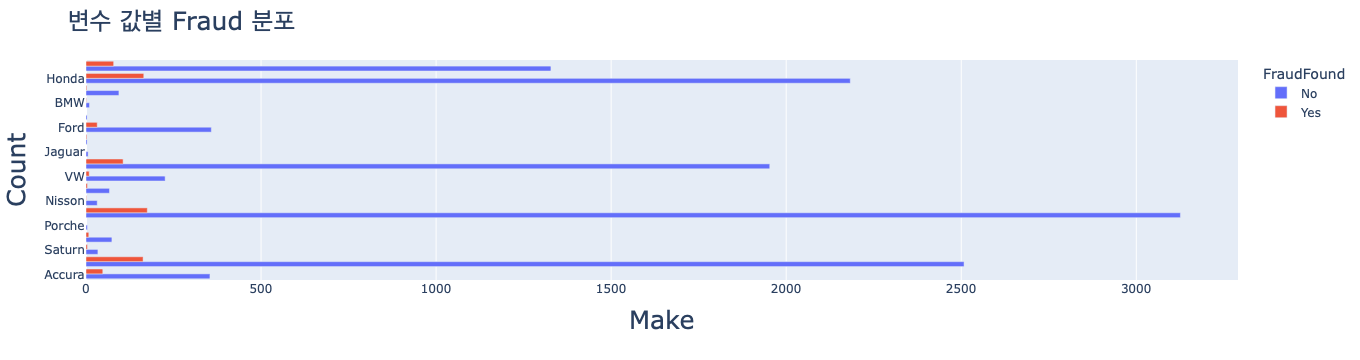

Make FraudFound  Count
32         VW        Yes      9
31         VW         No    226
30     Toyota        Yes    163
29     Toyota         No   2508
28     Saturn        Yes      4
27     Saturn         No     34
26       Saab        Yes      8
25       Saab         No     74
24     Porche         No      4
23    Pontiac        Yes    175
22    Pontiac         No   3126
21     Nisson        Yes      1
20     Nisson         No     32
19    Mercury        Yes      4
18    Mercury         No     67
17    Mecedes        Yes      2
16    Mecedes         No      3
15      Mazda        Yes    106
14      Mazda         No   1953
13     Jaguar         No      6
12      Honda        Yes    165
11      Honda         No   2183
10       Ford        Yes     32
9        Ford         No    358
8     Ferrari         No      3
7       Dodge        Yes      2
6       Dodge         No     94
5   Chevrolet        Yes     79
4   Chevrolet         No   1328
3         BMW        Yes      1
2         BMW         No     10
1      Accura        Yes     48
0      Accura         No    354

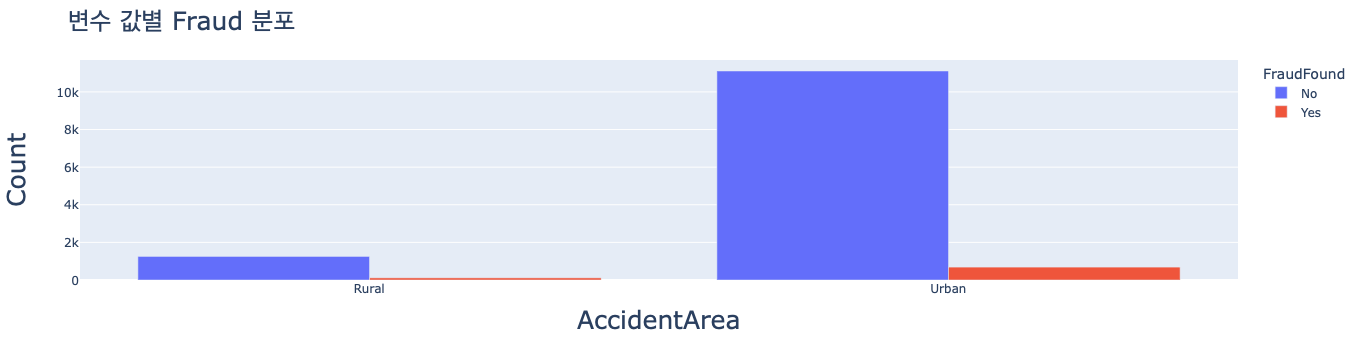

AccidentArea FraudFound  Count
3        Urban        Yes    685
2        Urban         No  11111
1        Rural        Yes    114
0        Rural         No   1252

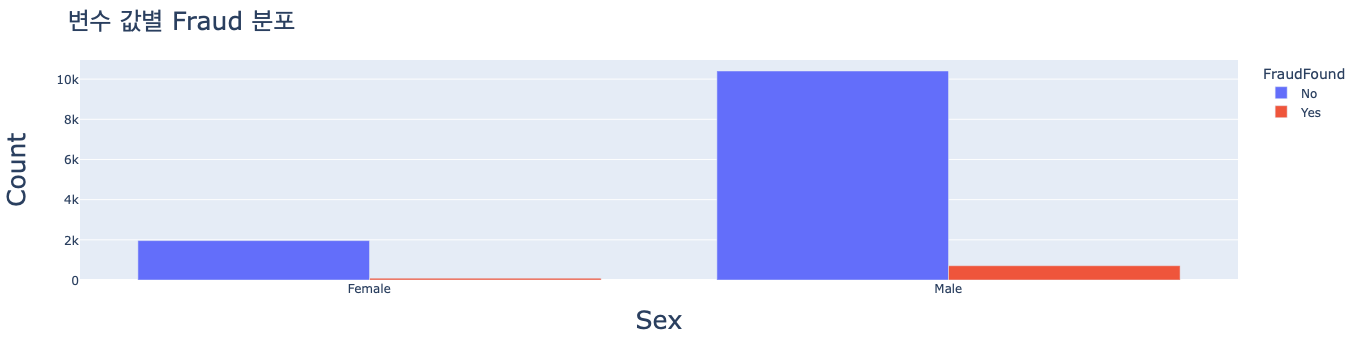

Sex FraudFound  Count
3    Male        Yes    711
2    Male         No  10403
1  Female        Yes     88
0  Female         No   1960

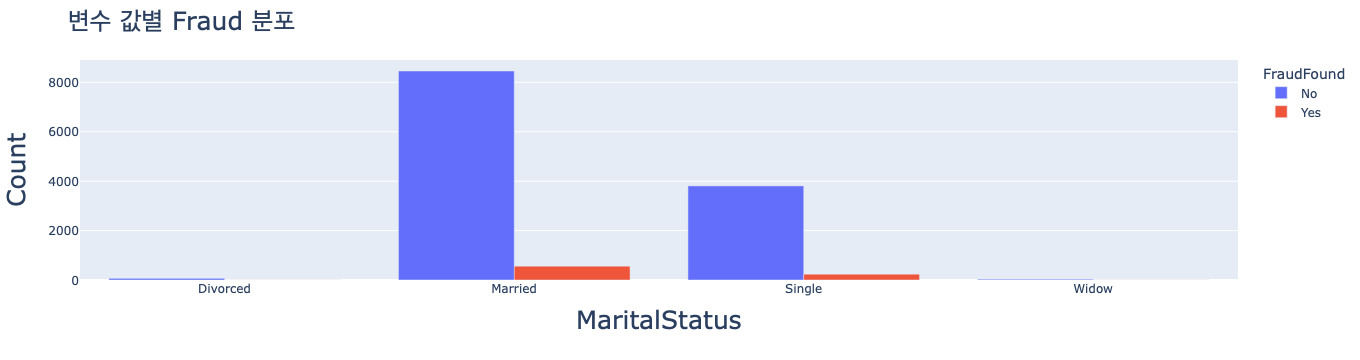

MaritalStatus FraudFound  Count
7         Widow        Yes      3
6         Widow         No     30
5        Single        Yes    235
4        Single         No   3808
3       Married        Yes    559
2       Married         No   8458
1      Divorced        Yes      2
0      Divorced         No     67

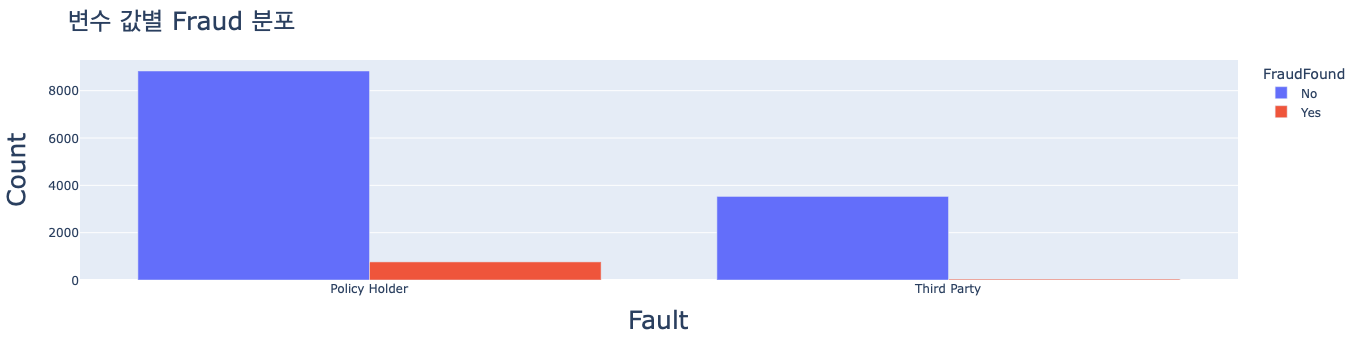

Fault FraudFound  Count
3    Third Party        Yes     34
2    Third Party         No   3531
1  Policy Holder        Yes    765
0  Policy Holder         No   8832

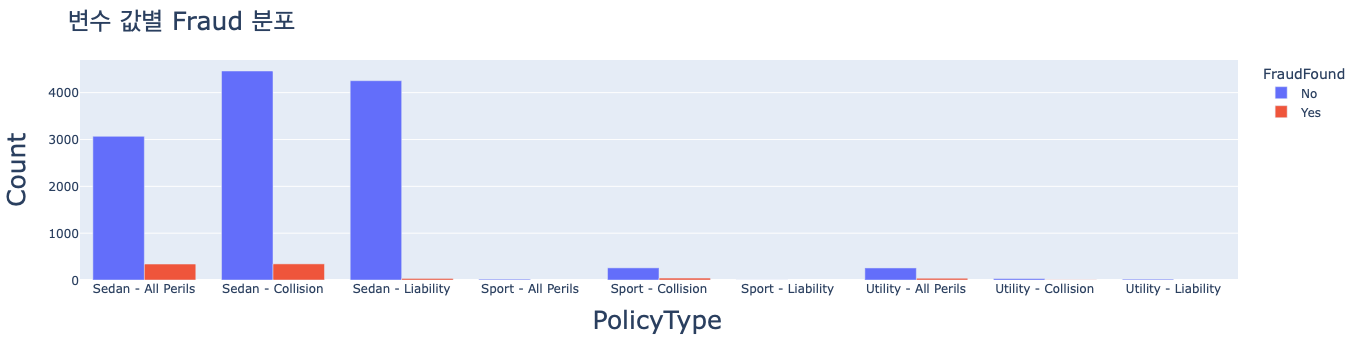

PolicyType FraudFound  Count
14   Utility - Liability         No     16
13   Utility - Collision        Yes      3
12   Utility - Collision         No     29
11  Utility - All Perils        Yes     37
10  Utility - All Perils         No    257
9      Sport - Liability         No      1
8      Sport - Collision        Yes     41
7      Sport - Collision         No    259
6     Sport - All Perils         No     16
5      Sedan - Liability        Yes     33
4      Sedan - Liability         No   4255
3      Sedan - Collision        Yes    344
2      Sedan - Collision         No   4462
1     Sedan - All Perils        Yes    341
0     Sedan - All Perils         No   3068

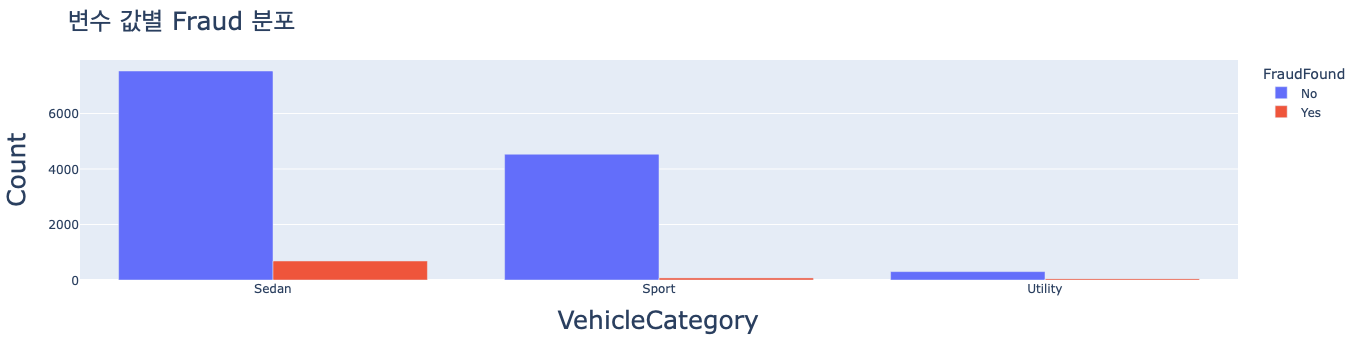

VehicleCategory FraudFound  Count
5         Utility        Yes     40
4         Utility         No    302
3           Sport        Yes     74
2           Sport         No   4531
1           Sedan        Yes    685
0           Sedan         No   7530

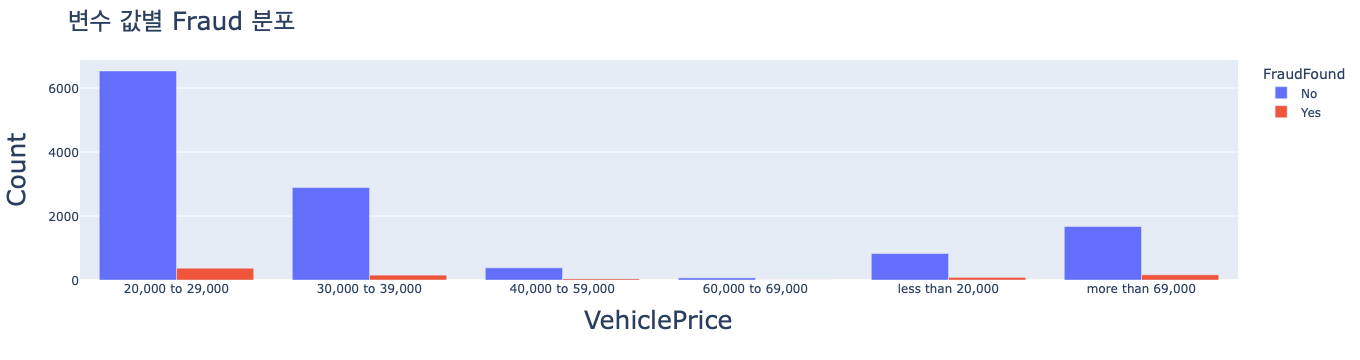

VehiclePrice FraudFound  Count
11  more than 69,000        Yes    162
10  more than 69,000         No   1671
9   less than 20,000        Yes     82
8   less than 20,000         No    825
7   60,000 to 69,000        Yes      2
6   60,000 to 69,000         No     66
5   40,000 to 59,000        Yes     33
4   40,000 to 59,000         No    380
3   30,000 to 39,000        Yes    152
2   30,000 to 39,000         No   2889
1   20,000 to 29,000        Yes    368
0   20,000 to 29,000         No   6532

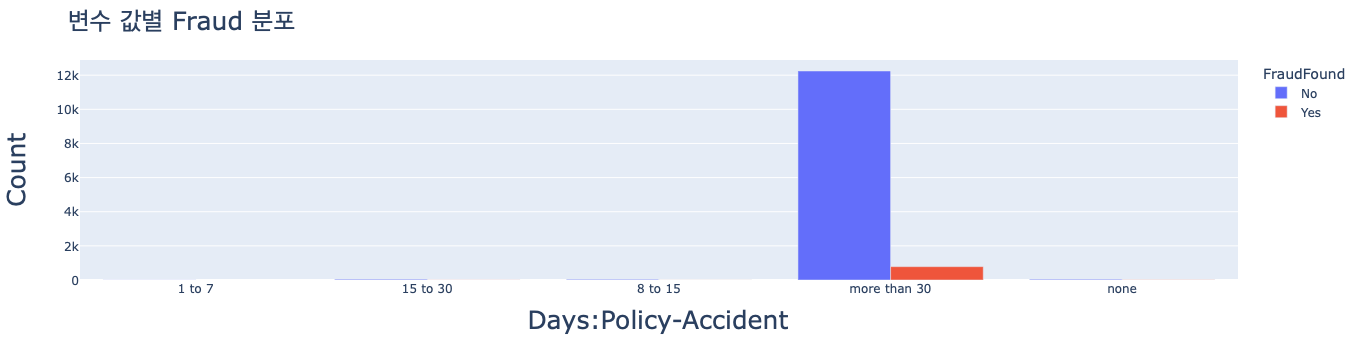

Days:Policy-Accident FraudFound  Count
8                 none        Yes     10
7                 none         No     38
6         more than 30        Yes    781
5         more than 30         No  12244
4              8 to 15        Yes      3
3              8 to 15         No     35
2             15 to 30        Yes      5
1             15 to 30         No     40
0               1 to 7         No      6

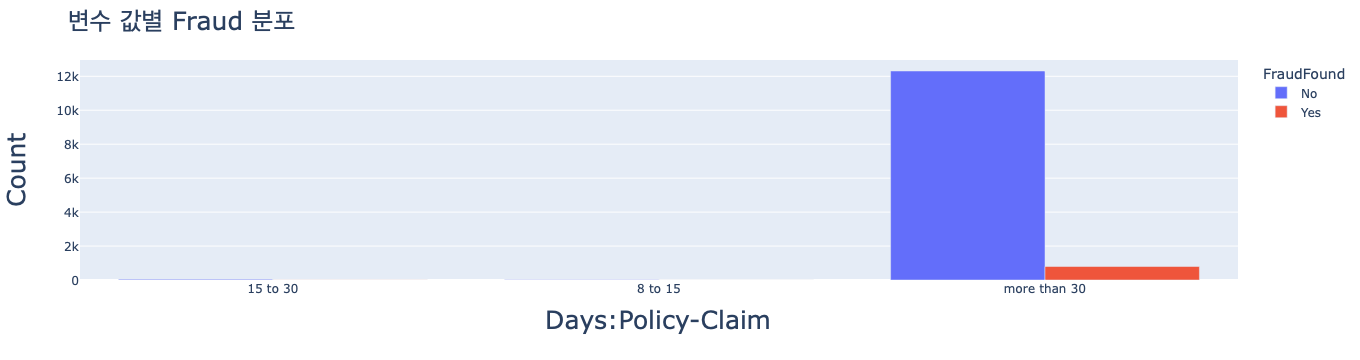

Days:Policy-Claim FraudFound  Count
5      more than 30        Yes    794
4      more than 30         No  12311
3           8 to 15        Yes      1
2           8 to 15         No     14
1          15 to 30        Yes      4
0          15 to 30         No     38

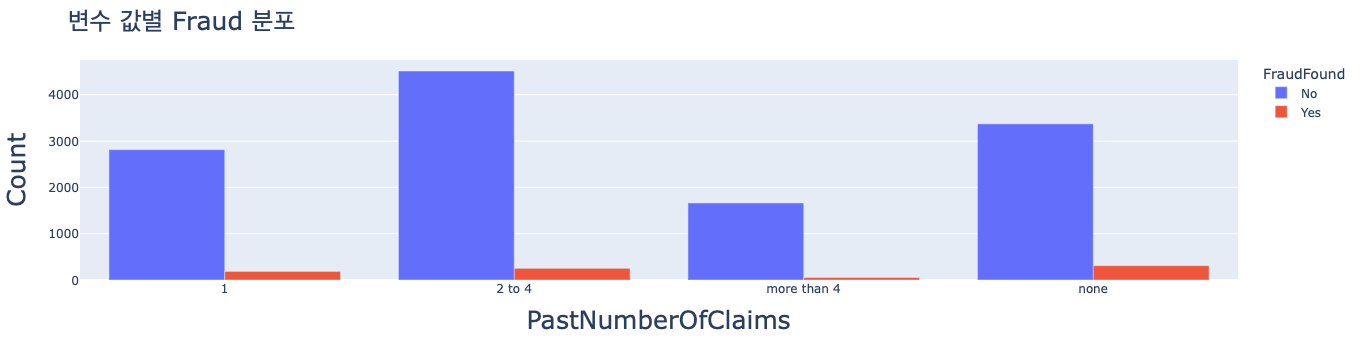

PastNumberOfClaims FraudFound  Count
7               none        Yes    309
6               none         No   3372
5        more than 4        Yes     53
4        more than 4         No   1664
3             2 to 4        Yes    252
2             2 to 4         No   4513
1                  1        Yes    185
0                  1         No   2814

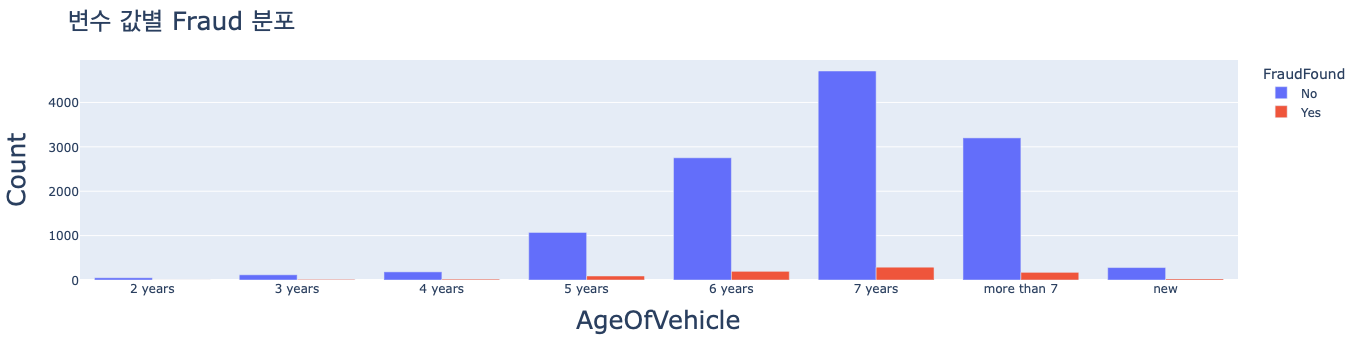

AgeOfVehicle FraudFound  Count
15          new        Yes     22
14          new         No    280
13  more than 7        Yes    172
12  more than 7         No   3201
11      7 years        Yes    288
10      7 years         No   4708
9       6 years        Yes    195
8       6 years         No   2753
7       5 years        Yes     90
6       5 years         No   1071
5       4 years        Yes     18
4       4 years         No    183
3       3 years        Yes     13
2       3 years         No    117
1       2 years        Yes      1
0       2 years         No     50

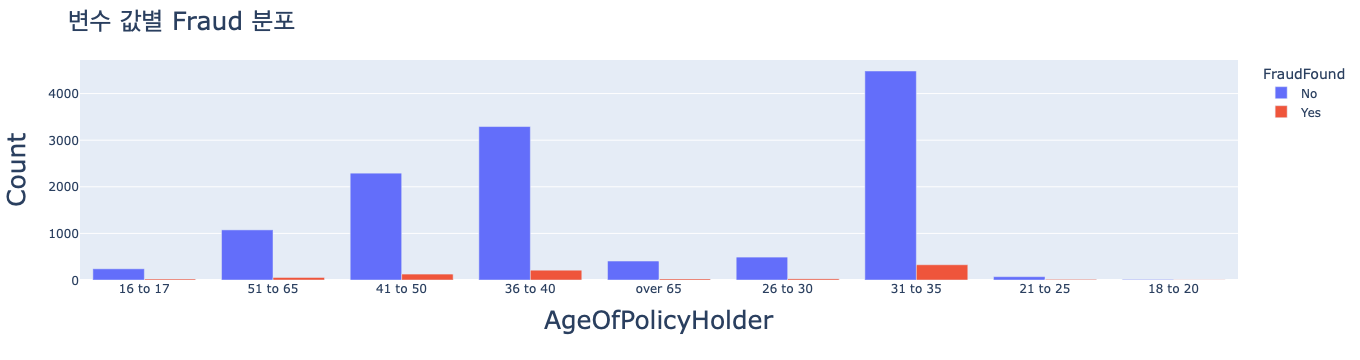

AgeOfPolicyHolder FraudFound  Count
17           over 65        Yes     21
16           over 65         No    407
15          51 to 65        Yes     54
14          51 to 65         No   1075
13          41 to 50        Yes    127
12          41 to 50         No   2292
11          36 to 40        Yes    210
10          36 to 40         No   3292
9           31 to 35        Yes    327
8           31 to 35         No   4484
7           26 to 30        Yes     24
6           26 to 30         No    491
5           21 to 25        Yes     13
4           21 to 25         No     71
3           18 to 20        Yes      3
2           18 to 20         No     11
1           16 to 17        Yes     20
0           16 to 17         No    240

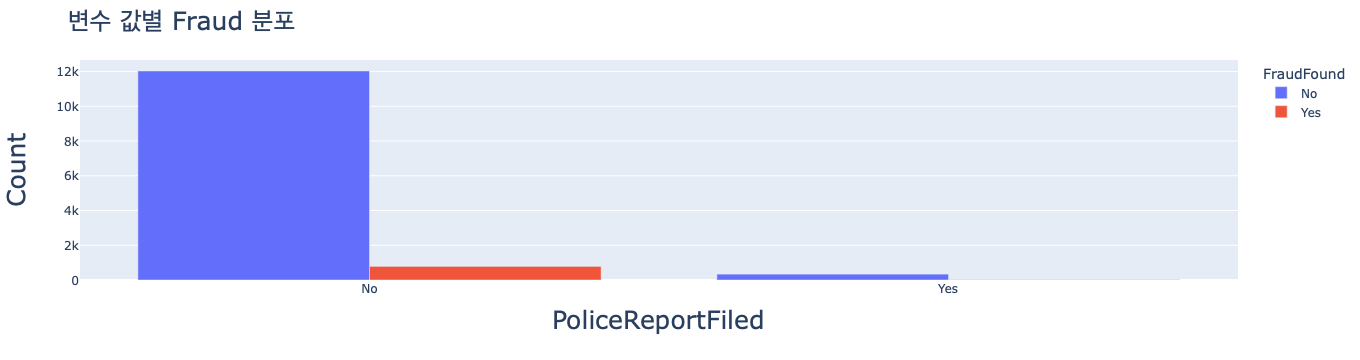

PoliceReportFiled FraudFound  Count
3               Yes        Yes     16
2               Yes         No    337
1                No        Yes    783
0                No         No  12026

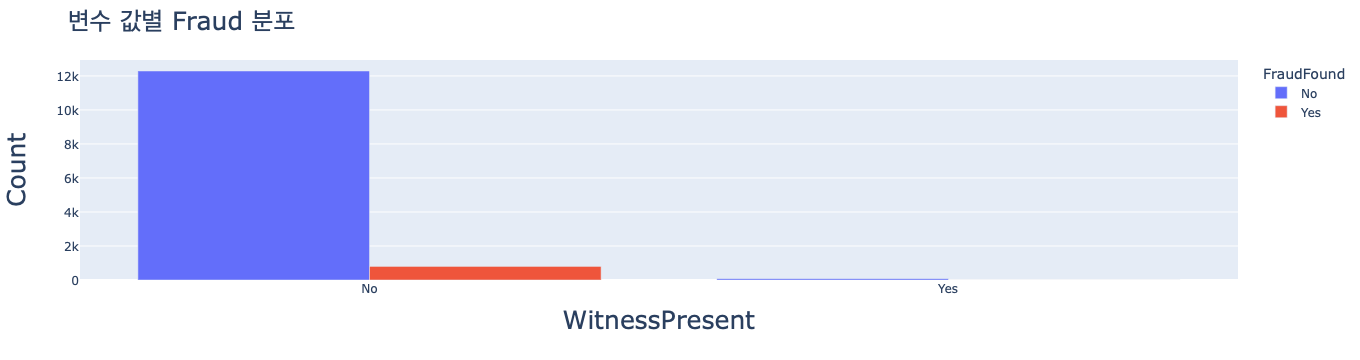

WitnessPresent FraudFound  Count
3            Yes        Yes      1
2            Yes         No     73
1             No        Yes    798
0             No         No  12290

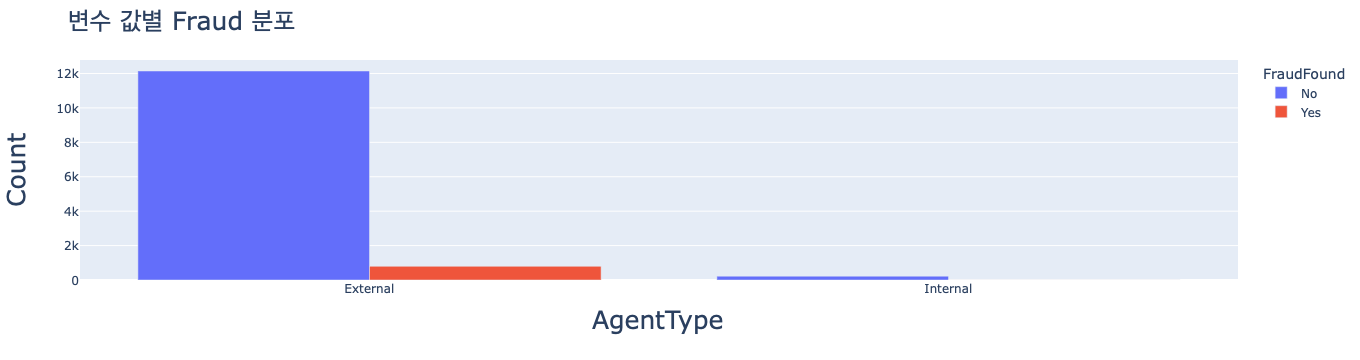

AgentType FraudFound  Count
3  Internal        Yes      2
2  Internal         No    219
1  External        Yes    797
0  External         No  12144

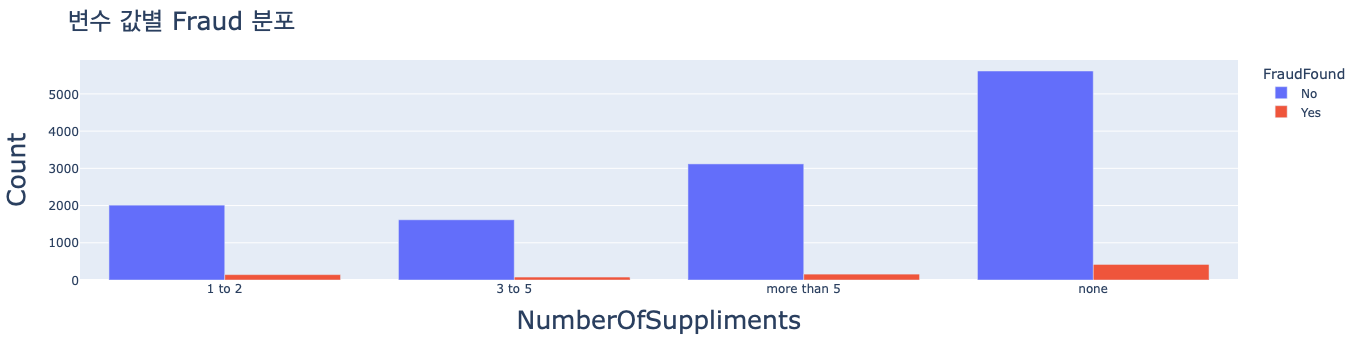

NumberOfSuppliments FraudFound  Count
7                none        Yes    418
6                none         No   5615
5         more than 5        Yes    158
4         more than 5         No   3119
3              3 to 5        Yes     79
2              3 to 5         No   1618
1              1 to 2        Yes    144
0              1 to 2         No   2011

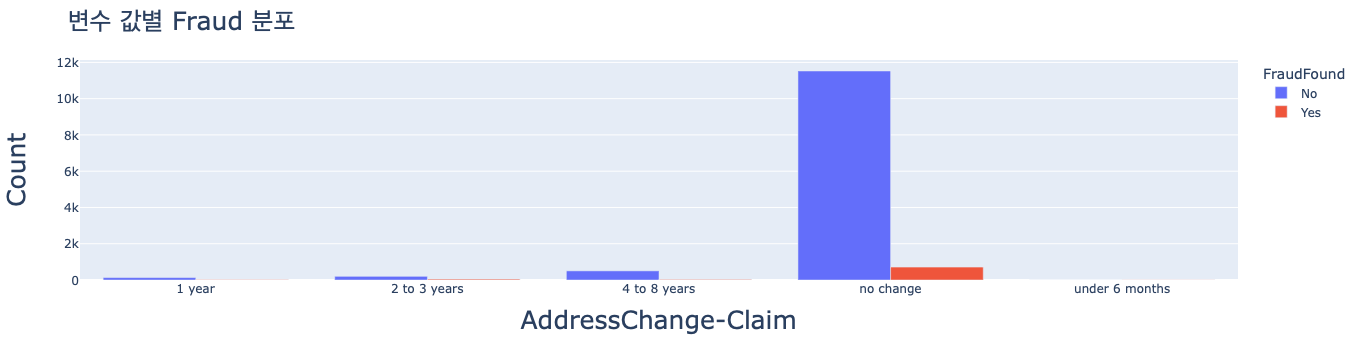

AddressChange-Claim FraudFound  Count
8      under 6 months        Yes      5
9      under 6 months         No      1
7           no change        Yes    713
6           no change         No  11525
5        4 to 8 years        Yes     25
4        4 to 8 years         No    503
3        2 to 3 years        Yes     43
2        2 to 3 years         No    202
1              1 year        Yes     13
0              1 year         No    132

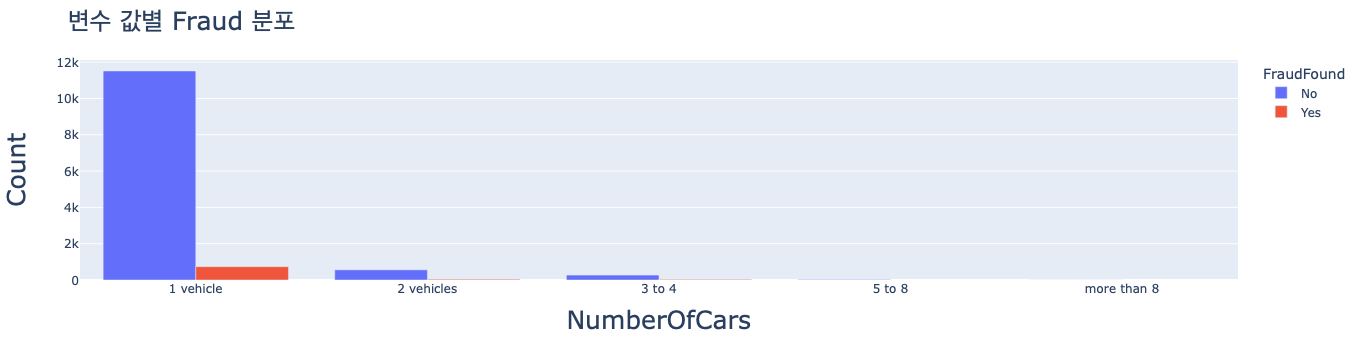

NumberOfCars FraudFound  Count
7  more than 8         No      1
6       5 to 8         No     19
5       3 to 4        Yes     30
4       3 to 4         No    271
3   2 vehicles        Yes     37
2   2 vehicles         No    560
1    1 vehicle        Yes    732
0    1 vehicle         No  11512

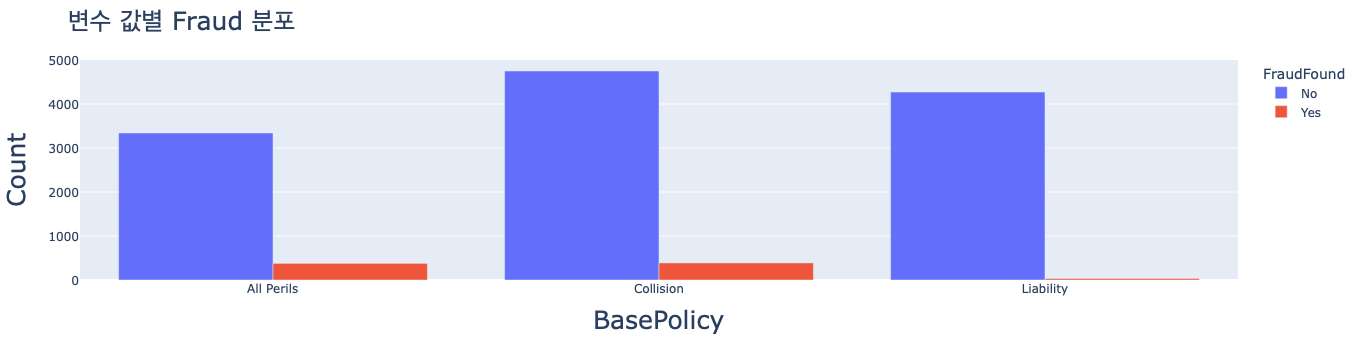

BasePolicy FraudFound  Count
5   Liability        Yes     33
4   Liability         No   4272
3   Collision        Yes    388
2   Collision         No   4750
1  All Perils        Yes    378
0  All Perils         No   3341

In [ ]:
for column in categorical_features_to_investigate :
    data_toplot = (
        data
        .groupby(column)
        ['FraudFound']
        .value_counts()
        .to_frame()
        .rename(columns={'FraudFound':'Count'})
        .reset_index(drop=False)
        .sort_values(by='FraudFound')
    )
    data_toplot[column] = data_toplot[column].astype(str)
    data_toplot['FraudFound'] = data_toplot['FraudFound'].astype(str)

    if data_toplot[column].unique().shape[0] < 10 :
        fig = px.bar(data_toplot, x=column, y='Count', color='FraudFound', barmode='group')
    else :
        fig = px.bar(data_toplot, x='Count', y=column, color='FraudFound', barmode='group', orientation='h')
    fig.update_layout(
        title=dict(
            text='변수 값별 Fraud 분포',
            font=dict(size=25),
        ),
        xaxis_title=dict(
            text=column,
            font=dict(size=25),
        ),
        yaxis_title=dict(
            text="Count",
            font=dict(size=25),
        ),
    )
    fig.show()
    display(data_toplot.sort_values(by=[column, 'FraudFound'], ascending=False))

#### (1) Numerical values
##### a) Correlation

In [ ]:
(
    data
    .loc[:, features_to_investigate]
    .select_dtypes('number')
)

Age  PolicyNumber  RepNumber  Deductible  DriverRating  Days_To_Report  \
0       60         10064          3         400             1              93   
1       45          2781         13         400             1               0   
2       49          3458         16         400             2               8   
3       29          3457          4         400             1              16   
4       25          8536         15         400             2              34   
...    ...           ...        ...         ...           ...             ...   
15415   44          7716         16         400             4               1   
15416   44         15005          7         700             3               1   
15417   21          3379          4         400             2               3   
15418   38          7228          9         400             2               6   
15419   54         14920         16         400             3               1   

       Date_Accident_Year  Date_Accident_Month  Date_Accident_Dayofmonth  \
0                    2015                    2                        22   
1                    2015                   11                        27   
2                    2015                    1                        15   
3                    2015                    5                        10   
4                    2015                   11                        17   
...                   ...                  ...                       ...   
15415                2016                    5                        25   
15416                2016                    7                        26   
15417                2016                   12                        12   
15418                2016                    9                        13   
15419                2016                   10                        26   

       Date_Accident_Weekofmonth  ...  Date_Accident_Weekofmonth_Cos  \
0                              4  ...                   1.000000e+00   
1                              4  ...                   1.000000e+00   
2                              3  ...                  -1.836970e-16   
3                              2  ...                  -1.000000e+00   
4                              3  ...                  -1.836970e-16   
...                          ...  ...                            ...   
15415                          4  ...                   1.000000e+00   
15416                          4  ...                   1.000000e+00   
15417                          2  ...                  -1.000000e+00   
15418                          2  ...                  -1.000000e+00   
15419                          4  ...                   1.000000e+00   

       Date_Accident_Month_Sin  Date_Accident_Dayofmonth_Sin  \
0                 8.660254e-01                     -0.968077   
1                -5.000000e-01                     -0.724793   
2                 5.000000e-01                      0.101168   
3                 5.000000e-01                      0.897805   
4                -5.000000e-01                     -0.299363   
...                        ...                           ...   
15415             5.000000e-01                     -0.937752   
15416            -5.000000e-01                     -0.848644   
15417            -2.449294e-16                      0.651372   
15418            -1.000000e+00                      0.485302   
15419            -8.660254e-01                     -0.848644   

       Date_Accident_Weekofmonth_Sin  Date_Claimed_Month_Cos  \
0                      -2.449294e-16           -8.660254e-01   
1                      -2.449294e-16            8.660254e-01   
2                      -1.000000e+00            8.660254e-01   
3                       1.224647e-16           -8.660254e-01   
4                      -1.000000e+00            1.000000e+00   
...                              ...                     ...   
15415                  -2.449294e-16   

In [ ]:
numerical_features_to_investigate = (
    data
    .loc[:, features_to_investigate]
    .select_dtypes('number')
    .columns
    .tolist()
)
numerical_features_to_investigate

['Age',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days_To_Report',
 'Date_Accident_Year',
 'Date_Accident_Month',
 'Date_Accident_Dayofmonth',
 'Date_Accident_Weekofmonth',
 'Date_Claimed_Year',
 'Date_Claimed_Month',
 'Date_Claimed_Dayofmonth',
 'Date_Claimed_Weekofmonth',
 'Date_Accident_Month_Cos',
 'Date_Accident_Dayofmonth_Cos',
 'Date_Accident_Weekofmonth_Cos',
 'Date_Accident_Month_Sin',
 'Date_Accident_Dayofmonth_Sin',
 'Date_Accident_Weekofmonth_Sin',
 'Date_Claimed_Month_Cos',
 'Date_Claimed_Dayofmonth_Cos',
 'Date_Claimed_Weekofmonth_Cos',
 'Date_Claimed_Month_Sin',
 'Date_Claimed_Dayofmonth_Sin',
 'Date_Claimed_Weekofmonth_Sin']

In [ ]:
(
    pd.concat(
        [
            (
                data
                .loc[:, numerical_features_to_investigate]
            ),
            (
                data['FraudFound']
            ),
        ],
        axis=1
    )
    .assign(FraudFound=lambda x : x['FraudFound'].apply(lambda y : 1 if y=='Yes' else 0))
)

Age  PolicyNumber  RepNumber  Deductible  DriverRating  Days_To_Report  \
0       60         10064          3         400             1              93   
1       45          2781         13         400             1               0   
2       49          3458         16         400             2               8   
3       29          3457          4         400             1              16   
4       25          8536         15         400             2              34   
...    ...           ...        ...         ...           ...             ...   
15415   44          7716         16         400             4               1   
15416   44         15005          7         700             3               1   
15417   21          3379          4         400             2               3   
15418   38          7228          9         400             2               6   
15419   54         14920         16         400             3               1   

       Date_Accident_Year  Date_Accident_Month  Date_Accident_Dayofmonth  \
0                    2015                    2                        22   
1                    2015                   11                        27   
2                    2015                    1                        15   
3                    2015                    5                        10   
4                    2015                   11                        17   
...                   ...                  ...                       ...   
15415                2016                    5                        25   
15416                2016                    7                        26   
15417                2016                   12                        12   
15418                2016                    9                        13   
15419                2016                   10                        26   

       Date_Accident_Weekofmonth  ...  Date_Accident_Month_Sin  \
0                              4  ...             8.660254e-01   
1                              4  ...            -5.000000e-01   
2                              3  ...             5.000000e-01   
3                              2  ...             5.000000e-01   
4                              3  ...            -5.000000e-01   
...                          ...  ...                      ...   
15415                          4  ...             5.000000e-01   
15416                          4  ...            -5.000000e-01   
15417                          2  ...            -2.449294e-16   
15418                          2  ...            -1.000000e+00   
15419                          4  ...            -8.660254e-01   

       Date_Accident_Dayofmonth_Sin  Date_Accident_Weekofmonth_Sin  \
0                         -0.968077                  -2.449294e-16   
1                         -0.724793                  -2.449294e-16   
2                          0.101168                  -1.000000e+00   
3                          0.897805                   1.224647e-16   
4                         -0.299363                  -1.000000e+00   
...                             ...                            ...   
15415                     -0.937752                  -2.449294e-16   
15416                     -0.848644                  -2.449294e-16   
15417                      0.651372                   1.224647e-16   
15418                      0.485302                   1.224647e-16   
15419                     -0.848644                  -2.449294e-16   

       Date_Claimed_Month_Cos  Date_Claimed_Dayofmonth_Cos  \
0               -8.660254e-01                     0.528964   
1                8.660254e-01                     0.688967   
2                8.660254e-01                    -0.050649   
3               -8.660254e-01                     0.528964   
4                1.000000e+00                    -0.440394   
...                       ...                          ...   
15415           -8.660254e-01                     0.5

In [ ]:
(
    (
        pd.concat(
            [
                (
                    data['FraudFound']
                ),
                (
                    data
                    .loc[:, numerical_features_to_investigate]
                ),
            ],
            axis=1
        )
    )
    .assign(FraudFound=lambda x : x['FraudFound'].apply(lambda y : 1 if y=='Yes' else 0))
    .corr()
    .style.background_gradient()

)

# **🥇Session 3**  
**┗ 이상 탐지 모델링**  
---

### · 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature (X)와 예측하고자하는 값인 Y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할

In [ ]:
data.iloc[:4].T

0                    1  \
Make                                         Mazda              Pontiac   
AccidentArea                                 Urban                Urban   
Sex                                           Male               Female   
MaritalStatus                              Married               Single   
Age                                             60                   45   
Fault                                Policy Holder        Policy Holder   
PolicyType                       Sedan - Collision    Sedan - Liability   
VehicleCategory                              Sedan                Sport   
VehiclePrice                      20,000 to 29,000     less than 20,000   
PolicyNumber                                 10064                 2781   
RepNumber                                        3                   13   
Deductible                                     400                  400   
DriverRating                                     1                    1   
Days:Policy-Accident                  more than 30         more than 30   
Days:Policy-Claim                     more than 30         more than 30   
PastNumberOfClaims                          2 to 4          more than 4   
AgeOfVehicle                           more than 7              7 years   
AgeOfPolicyHolder                         51 to 65             36 to 40   
PoliceReportFiled                               No                   No   
WitnessPresent                                  No                   No   
AgentType                                 External             External   
NumberOfSuppliments                         3 to 5               1 to 2   
AddressChange-Claim                      no change            no change   
NumberOfCars                             1 vehicle            1 vehicle   
BasePolicy                               Collision            Liability   
FraudFound                                      No                   No   
Date_Accident                  2015-02-22 00:00:00  2015-11-27 00:00:00   
Date_Claimed                   2015-05-26 00:00:00  2015-11-27 00:00:00   
Days_To_Report                                  93                    0   
Date_Accident_Year                            2015                 2015   
Date_Accident_Month                              2                   11   
Date_Accident_Dayofmonth                        22                   27   
Date_Accident_Weekofmonth                        4                    4   
Date_Claimed_Year                             2015                 2015   
Date_Claimed_Month                               5                   11   
Date_Claimed_Dayofmonth                         26                   27   
Date_Claimed_Weekofmonth                         4                    4   
Date_Accident_Month_Cos                        0.5             0.866025   
Date_Accident_Dayofmonth_Cos             -0.250653             0.688967   
Date_Accident_Weekofmonth_Cos                  1.0                  1.0   
Date_Accident_Month_Sin                   0.866025                 -0.5   
Date_Accident_Dayofmonth_Sin             -0.968077            -0.724793   
Date_Accident_Weekofmonth_Sin                 -0.0                 -0.0   
Date_Claimed_Month_Cos                   -0.866025             0.866025   
Date_Claimed_Dayofmonth_Cos               0.528964             0.688967   
Date_Claimed_Weekofmonth_Cos                   1.0                  1.0   
Date_Claimed_Month_Sin                         0.5                 -0.5   
Date_Claimed_Dayofmonth_Sin              -0.848644            -0.724793   
Date_Claimed_Weekofmonth_Sin                  -0.0                 -0.0   

                                                 2                    3  
Make                                         Dodge                Mazda  
AccidentArea                                 Urban                Rural  
Sex                                           Male                 Male  
Ma

In [ ]:
dataset = (
    data
    .loc[:, (
        categorical_features_to_investigate
        + numerical_features_to_investigate
        + ['FraudFound']
    )
        ]
)
dataset.T

0                  1      \
Make                                       Mazda            Pontiac   
AccidentArea                               Urban              Urban   
Sex                                         Male             Female   
MaritalStatus                            Married             Single   
Fault                              Policy Holder      Policy Holder   
PolicyType                     Sedan - Collision  Sedan - Liability   
VehicleCategory                            Sedan              Sport   
VehiclePrice                    20,000 to 29,000   less than 20,000   
Days:Policy-Accident                more than 30       more than 30   
Days:Policy-Claim                   more than 30       more than 30   
PastNumberOfClaims                        2 to 4        more than 4   
AgeOfVehicle                         more than 7            7 years   
AgeOfPolicyHolder                       51 to 65           36 to 40   
PoliceReportFiled                             No                 No   
WitnessPresent                                No                 No   
AgentType                               External           External   
NumberOfSuppliments                       3 to 5             1 to 2   
AddressChange-Claim                    no change          no change   
NumberOfCars                           1 vehicle          1 vehicle   
BasePolicy                             Collision          Liability   
Age                                           60                 45   
PolicyNumber                               10064               2781   
RepNumber                                      3                 13   
Deductible                                   400                400   
DriverRating                                   1                  1   
Days_To_Report                                93                  0   
Date_Accident_Year                          2015               2015   
Date_Accident_Month                            2                 11   
Date_Accident_Dayofmonth                      22                 27   
Date_Accident_Weekofmonth                      4                  4   
Date_Claimed_Year                           2015               2015   
Date_Claimed_Month                             5                 11   
Date_Claimed_Dayofmonth                       26                 27   
Date_Claimed_Weekofmonth                       4                  4   
Date_Accident_Month_Cos                      0.5           0.866025   
Date_Accident_Dayofmonth_Cos           -0.250653           0.688967   
Date_Accident_Weekofmonth_Cos                1.0                1.0   
Date_Accident_Month_Sin                 0.866025               -0.5   
Date_Accident_Dayofmonth_Sin           -0.968077          -0.724793   
Date_Accident_Weekofmonth_Sin               -0.0               -0.0   
Date_Claimed_Month_Cos                 -0.866025           0.866025   
Date_Claimed_Dayofmonth_Cos             0.528964           0.688967   
Date_Claimed_Weekofmonth_Cos                 1.0                1.0   
Date_Claimed_Month_Sin                       0.5               -0.5   
Date_Claimed_Dayofmonth_Sin            -0.848644          -0.724793   
Date_Claimed_Weekofmonth_Sin                -0.0               -0.0   
FraudFound                                    No                 No   

                                           2                  3      \
Make                                       Dodge              Mazda   
AccidentArea                               Urban              Rural   
Sex                                         Male               Male   
MaritalStatus                            Married             Single   
Fault                              Policy Holder      Policy Holder   
PolicyType                     Sedan - Liability  Sedan - Collision   
VehicleCategory                            Sport              Sedan   
VehiclePrice                    more than 69,000   20,000 to 29,00

In [ ]:
categorical_features = categorical_features_to_investigate
numerical_features = numerical_features_to_investigate
target_value='FraudFound'

In [ ]:
categorical_features

['Make',
 'AccidentArea',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Days:Policy-Accident',
 'Days:Policy-Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange-Claim',
 'NumberOfCars',
 'BasePolicy']

In [ ]:
numerical_features

['Age',
 'PolicyNumber',
 'RepNumber',
 'Deductible',
 'DriverRating',
 'Days_To_Report',
 'Date_Accident_Year',
 'Date_Accident_Month',
 'Date_Accident_Dayofmonth',
 'Date_Accident_Weekofmonth',
 'Date_Claimed_Year',
 'Date_Claimed_Month',
 'Date_Claimed_Dayofmonth',
 'Date_Claimed_Weekofmonth',
 'Date_Accident_Month_Cos',
 'Date_Accident_Dayofmonth_Cos',
 'Date_Accident_Weekofmonth_Cos',
 'Date_Accident_Month_Sin',
 'Date_Accident_Dayofmonth_Sin',
 'Date_Accident_Weekofmonth_Sin',
 'Date_Claimed_Month_Cos',
 'Date_Claimed_Dayofmonth_Cos',
 'Date_Claimed_Weekofmonth_Cos',
 'Date_Claimed_Month_Sin',
 'Date_Claimed_Dayofmonth_Sin',
 'Date_Claimed_Weekofmonth_Sin']

In [ ]:
target_value

'FraudFound'

### · 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가
* 참고 자료
    - [Pycaret:Classification](https://pycaret.readthedocs.io/en/stable/api/classification.html)
    


#### 1) 모델 학습

![](figures/16_5.png)

- 과거에는 Scikit-learn, Pytorch등의 패키지등을 통해 모델과 전/후처리 파이프라인들을 개별적으로 설정하여 모델 비교를 위한 실험 코드를 작성
- 여러 프로젝트에서 동일한 코드를 반복적으로 작성/사용하게 되며 이로 인한 효율이 떨어짐
- 이미 알려지고 사용되고 있는 모델들을 한꺼번에 실험할수 있는 인터페이스가 필요 -> `Pycaret` 활용하여 빠르게 여러 모델간의 성능 비교가 가능

In [ ]:
!pip install pycaret==3.0.0rc4


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from pycaret.classification import ClassificationExperiment

experiment_name = 'chapter_22'
exp = ClassificationExperiment()

- 실험 수행

In [ ]:
exp.setup(
    data=dataset,
    target=target_value,
    train_size=0.8,
    categorical_features=categorical_features,
    numeric_features=numerical_features,
    normalize=True,
    fold_strategy='kfold',
    fold_shuffle=True,
    fold=5,
    experiment_name=experiment_name
)

- 실험 결과 확인
    - AUC, Recall, Prec.(Precision) 확인

In [ ]:
models = exp.compare_models(sort='AUC', n_select=5)

[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.
[LightGBM] [Fatal] Do not support special JSON characters in feature name.


#### 2) 모델 평가

- Extra Tree Classifier

![](figures/16_7.png)

In [ ]:
model = models[0]

##### a) Confusion matrix
![](figures/16_3.png)

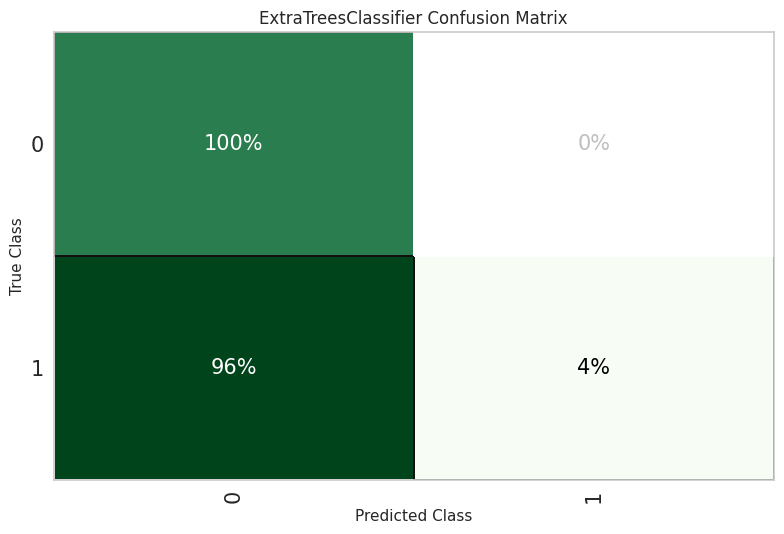

In [ ]:
exp.plot_model(model, plot='confusion_matrix', plot_kwargs={'percent':True})

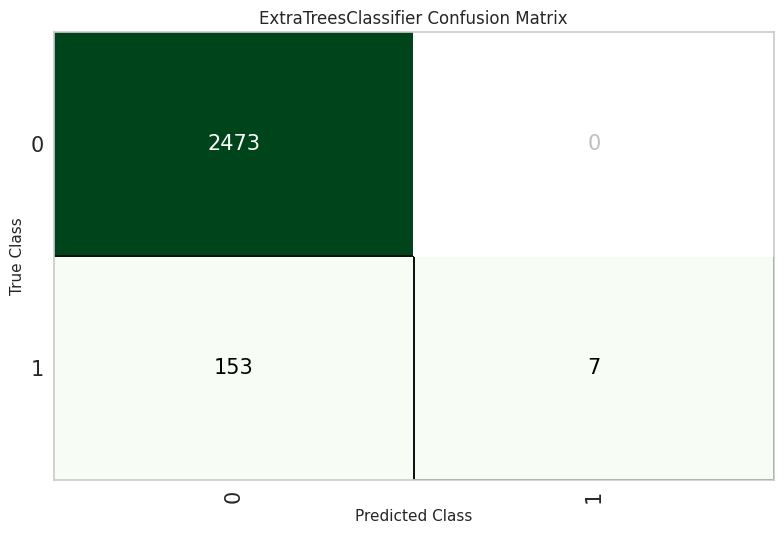

In [ ]:
exp.plot_model(model, plot='confusion_matrix')

##### b) AUROC

![](figures/16_2.png)
![](figures/16_4.png)

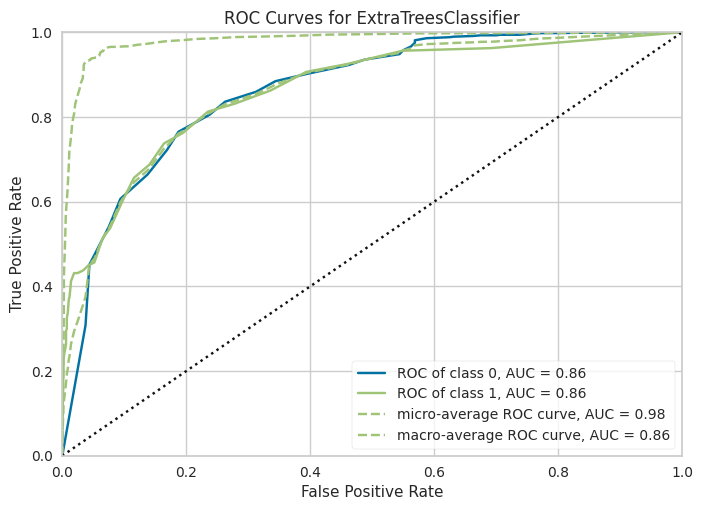

In [ ]:
exp.plot_model(model, plot='auc')

#### 2) 모델 해석

##### a) 모델 Threshold

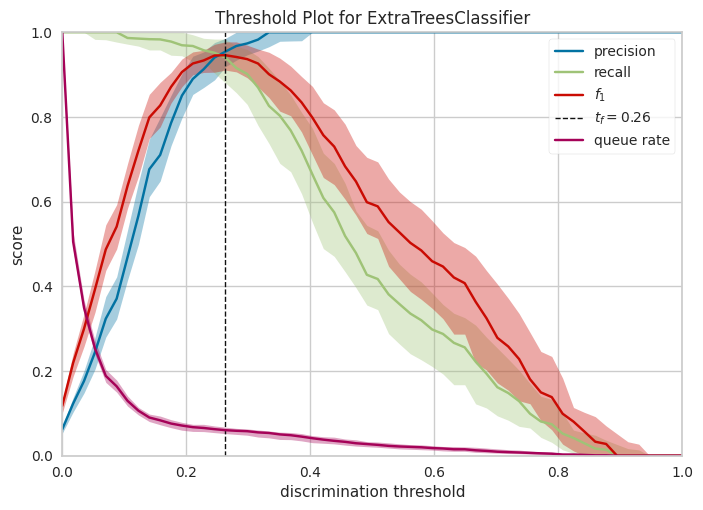

In [ ]:
exp.plot_model(model, plot='threshold')

##### b) 모델 Training history

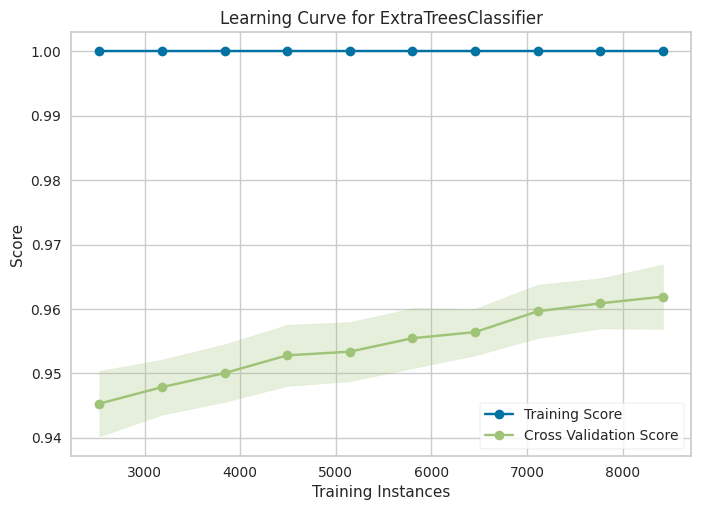

In [ ]:
exp.plot_model(model, plot='learning')

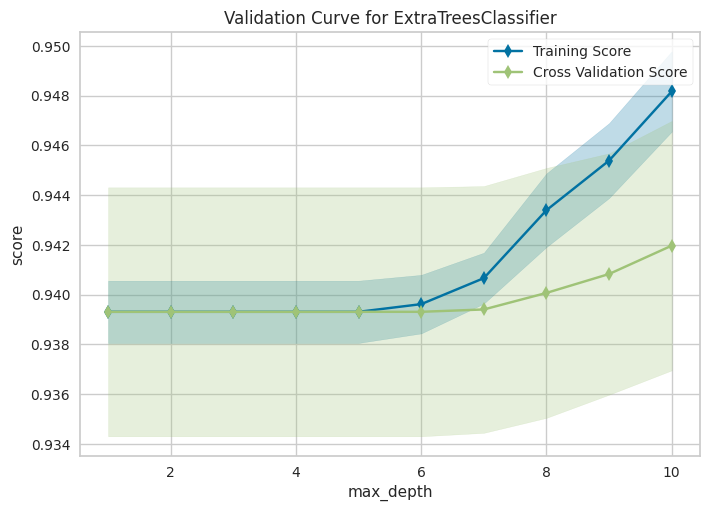

In [ ]:
exp.plot_model(model, plot='vc')

##### c) 모델 Decision boundary 시각화
![](figures/16_6.png)

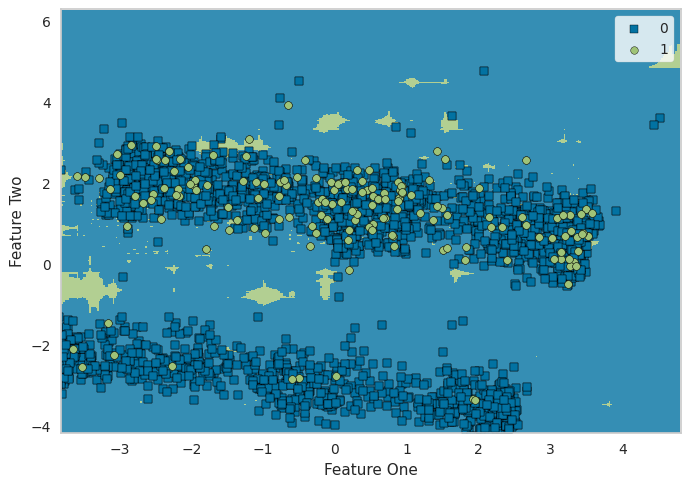

In [ ]:
exp.plot_model(model, plot='boundary')

### · 중요 변수 파악
---
* Feature importance 분석을 통한 중요변수 파악


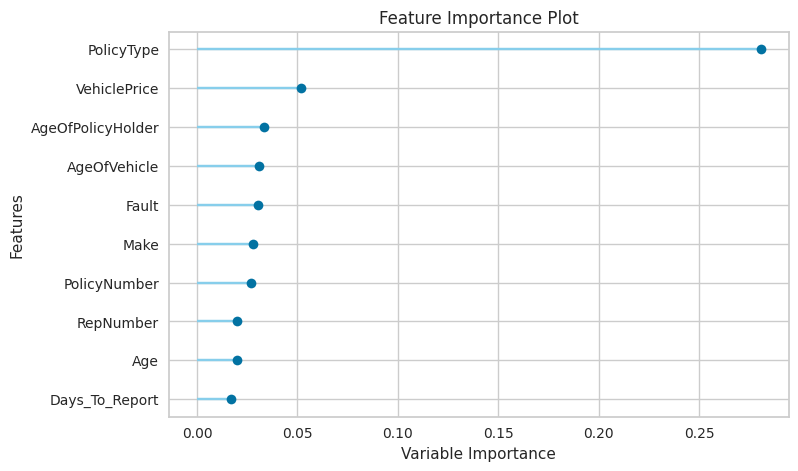

In [ ]:
exp.plot_model(model, plot='feature')

- RFE (Recursive feature elimiation)

In [ ]:
# exp.plot_model(model, plot='rfe')


### · 모델 확인
---
* 실험으로부터 사용할 수 있는 모델을 불러오기

In [ ]:
model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=7013, verbose=0, warm_start=False)

In [ ]:
model_finalized = exp.finalize_model(model)

In [ ]:
x_test = exp.X_test
x_test

Make AccidentArea     Sex MaritalStatus          Fault  \
10529  Pontiac        Urban    Male       Married    Third Party   
10530   Accura        Urban    Male       Married  Policy Holder   
10531   Toyota        Urban    Male       Married  Policy Holder   
10532   Toyota        Urban    Male       Married  Policy Holder   
10533  Pontiac        Rural    Male       Married  Policy Holder   
...        ...          ...     ...           ...            ...   
13157  Pontiac        Urban  Female        Single  Policy Holder   
13158  Pontiac        Urban    Male       Married  Policy Holder   
13159  Pontiac        Urban    Male        Single    Third Party   
13160  Pontiac        Urban    Male       Married    Third Party   
13161  Pontiac        Rural    Male        Single    Third Party   

               PolicyType VehicleCategory      VehiclePrice  \
10529  Sedan - All Perils           Sedan  less than 20,000   
10530   Sedan - Liability           Sport  30,000 to 39,000   
10531  Sedan - All Perils           Sedan  20,000 to 29,000   
10532   Sedan - Collision           Sedan  20,000 to 29,000   
10533   Sedan - Liability           Sport  30,000 to 39,000   
...                   ...             ...               ...   
13157  Sedan - All Perils           Sedan  less than 20,000   
13158   Sedan - Collision           Sedan  20,000 to 29,000   
13159  Sedan - All Perils           Sedan  less than 20,000   
13160   Sedan - Liability           Sport  20,000 to 29,000   
13161  Sedan - All Perils           Sedan  20,000 to 29,000   

      Days:Policy-Accident Days:Policy-Claim  ...  \
10529                 none      more than 30  ...   
10530         more than 30      more than 30  ...   
10531         more than 30      more than 30  ...   
10532         more than 30      more than 30  ...   
10533         more than 30      more than 30  ...   
...                    ...               ...  ...   
13157         more than 30      more than 30  ...   
13158         more than 30      more than 30  ...   
13159         more than 30      more than 30  ...   
13160         more than 30      more than 30  ...   
13161         more than 30      more than 30  ...   

      Date_Accident_Weekofmonth_Cos Date_Accident_Month_Sin  \
10529                 -1.836970e-16           -2.449294e-16   
10530                 -1.836970e-16           -5.000000e-01   
10531                  6.123234e-17            8.660254e-01   
10532                  1.000000e+00           -5.000000e-01   
10533                  1.000000e+00           -5.000000e-01   
...                             ...                     ...   
13157                  6.123234e-17            1.224647e-16   
13158                  3.061617e-16            5.000000e-01   
13159                 -1.000000e+00           -2.449294e-16   
13160                 -1.836970e-16            5.000000e-01   
13161                 -1.836970e-16            8.660254e-01   

      Date_Accident_Dayofmonth_Sin Date_Accident_Weekofmonth_Sin  \
10529                    -0.485302                 -1.000000e+00   
10530                    -0.101168                 -1.000000e+00   
10531                     0.201299                  1.000000e+00   
10532                    -0.848644                 -2.449294e-16   
10533                    -0.724793                 -2.449294e-16   
...                            ...                           ...   
13157                     0.571268                  1.000000e+00   
13158                    -0.201299                  1.000000e+00   
13159                     0.897805                  1.224647e-16   
13160                    -0.651372                 -1.000000e+00   
13161                    -0.485302                 -1.000000e+00   

      Date_Claimed_Month_Cos Date_Claimed_Dayofmonth_Cos  \
10529               0.866025                   -0.612106   
10530              -0.866025                   -0.874347   
10531              -0.500000                 

In [ ]:
y_test = exp.y_test
y_test

10529    Yes
10530     No
10531     No
10532     No
10533     No
        ... 
13157     No
13158     No
13159     No
13160     No
13161     No
Name: FraudFound, Length: 2633, dtype: category
Categories (2, object): ['No', 'Yes']

In [ ]:
from sklearn.metrics import roc_auc_score

yhat_test = model_finalized.predict(x_test)
roc_auc_score(
    yhat_test.apply(lambda x : 1 if x=='Yes' else 0),
    y_test.apply(lambda x : 1 if x=='Yes' else 0),
)

0.9885420782299487


### · 모델 Save and Read
---
* 최종 모델을 저장 및 다시 불러오기

In [ ]:
exp.save_model(
    model=model_finalized,
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=/tmp/joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Age', 'PolicyNumber', 'RepNumber',
                                              'Deductible', 'DriverRating',
                                              'Days_To_Report',
                                              'Date_Accident_Year',
                                              'Date_Accident_Month',
                                              'Date_Accide...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=None, max_features='sqrt',
                             

In [ ]:
model_loaded = exp.load_model(
    model_name=f'model_{experiment_name}_v1'
)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
model_loaded.predict(x_test)

0       Yes
1        No
2        No
3        No
4        No
       ... 
2628     No
2629     No
2630     No
2631     No
2632     No
Name: target, Length: 2633, dtype: object